In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 3.1 MB 15.3 MB/s 
     |████████████████████████████████| 290 kB 73.8 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 895 kB 77.4 MB/s 
     |████████████████████████████████| 59 kB 9.1 MB/s 
     |████████████████████████████████| 1.1 MB 67.8 MB/s 
     |████████████████████████████████| 243 kB 66.3 MB/s 
     |████████████████████████████████| 132 kB 69.7 MB/s 
     |████████████████████████████████| 160 kB 72.0 MB/s 
     |████████████████████████████████| 192 kB 76.4 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [35]:
emotion_dataset["train"]["text"][27]

'i become overwhelmed and feel defeated'

In [36]:
emotion_dataset["train"]["label"][27]

0

In [ ]:
emotion_dataset["train"]["label"][:20]

[0, 0, 3, 2, 3, 0, 5, 4, 1, 2, 0, 1, 3, 0, 1, 1, 0, 0, 0, 4]

In [ ]:
np.unique(emotion_dataset["train"]["label"])

array([0, 1, 2, 3, 4, 5])

In [ ]:
np.unique(emotion_dataset["validation"]["label"])

array([0, 1, 2, 3, 4, 5])

In [ ]:
np.unique(emotion_dataset["test"]["label"])

array([0, 1, 2, 3, 4, 5])

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [37]:
tokenizer.tokenize(emotion_dataset["train"]["text"][27])

['i', 'Ġbecome', 'Ġoverwhelmed', 'Ġand', 'Ġfeel', 'Ġdefeated']

In [38]:
tokenizer.encode(emotion_dataset["train"]["text"][27])

[72, 1716, 20974, 290, 1254, 9772]

In [39]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][27])

{'input_ids': [72, 1716, 20974, 290, 1254, 9772], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [40]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][27], return_tensors="pt")

{'input_ids': tensor([[   72,  1716, 20974,   290,  1254,  9772]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [41]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][27], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt" # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72,  1716, 20974,   290,  1254,  9772, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [44]:
# Если надо, попрактикуйся работать с токенайзером здесь

data_27 = tokenizer.encode_plus(
    emotion_dataset["train"]["text"][27], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt" # возвращает pytorch тензоры
)

data_27['input_ids'].shape, data_27['attention_mask'].shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [ ]:
data_all = tokenizer.batch_encode_plus(
    emotion_dataset["train"]["text"], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt" # возвращает pytorch тензоры
)

data_all['input_ids'].shape, data_all['attention_mask'].shape

(torch.Size([16000, 128]), torch.Size([16000, 128]))

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        # self.label2num = {l: num for num, l in enumerate(self.labels)}
        # перевод в числа можно здесь опустить, т.к. лейблы и так числа
        # иначе {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = tokenizer.encode_plus(text, max_length=128, 
                                                 padding="max_length", 
                                                 return_tensors="pt")
        # target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            "mask": tokenizer_output['attention_mask'][0],
            'target': label
            # 'target': target
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train', emotion_dataset, tokenizer, max_length=128)
valid_dataset = TweetDataset('validation', emotion_dataset, tokenizer, max_length=128)
test_dataset = TweetDataset('test', emotion_dataset, tokenizer, max_length=128)

In [ ]:
# train_dataset.label2num

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, drop_last=True)

In [ ]:
next(iter(train_loader))

{'input_ids': tensor([[   72,  1254, 40102,  ..., 50256, 50256, 50256],
         [   72,   466,   407,  ..., 50256, 50256, 50256],
         [   72,   716,   994,  ..., 50256, 50256, 50256],
         ...,
         [   72,  1254,   588,  ..., 50256, 50256, 50256],
         [   72,   373,  4203,  ..., 50256, 50256, 50256],
         [   72,   373,  4203,  ..., 50256, 50256, 50256]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([3, 1, 4, 0, 1, 1, 3, 0, 2, 1, 2, 1, 0, 3, 1, 4, 1, 1, 0, 2, 0, 1, 4, 1,
         3, 0, 2, 2, 0, 1, 3, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 4, 1, 4, 0, 1,
         0, 1, 0, 4, 1, 1, 0, 0, 3, 1, 1, 3, 0, 1, 1, 3])}

In [ ]:
x = next(iter(train_loader))

In [ ]:
x['input_ids'].shape

torch.Size([64, 128])

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [53]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6 # не 8, как написано было изначально!
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [54]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [55]:
tr_batch = next(iter(train_loader))

tokens = tr_batch['input_ids'].to(device) # Получи токены из датасета
mask = tr_batch['mask'].to(device) # Получи маску из датасета

output = model_0(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут

In [ ]:
output.keys()

odict_keys(['logits', 'past_key_values', 'attentions'])

In [ ]:
output['logits'].shape, output['logits'][0].shape # (num_labels)

(torch.Size([64, 6]), torch.Size([6]))

In [ ]:
len(output['past_key_values']), len(output['past_key_values'][0]), output['past_key_values'][0][0].shape # (batch_s, n_heads, seq_length, head_feature_dim)

(6, 2, torch.Size([64, 12, 128, 64]))

In [ ]:
len(output['attentions']), output['attentions'][0].shape # (batch_s, n_heads, seq_length, seq_length)

(6, torch.Size([64, 12, 128, 128]))

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [56]:
from tqdm.notebook import tqdm

num_epochs = 10
CLIP = 3
best_valid_acc = -np.inf

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_acc = 0
    train_loss = 0
    for batch in tqdm(train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_0(input_ids=tokens, attention_mask=mask)

        loss = criterion(output['logits'], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), CLIP)

        train_loss += loss.cpu().detach()
        train_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

        optimizer.step()

    valid_acc = 0
    valid_loss = 0
    model_0.eval()

    with torch.no_grad():
        for batch in valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_0(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          valid_loss += loss.cpu().detach()
          valid_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

 
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Train Acc: {train_acc / len(train_loader)},"
          f"Valid Acc: {valid_acc /  len(valid_loader)}")     

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_0.state_dict(), 'best_valid_acc_model_0.pt')      
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_0(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          test_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

print(f"Test Acc: {test_acc / len(test_loader)}")


# Train Loss: 0.11969923973083496,Valid Loss: 0.39514052867889404,Train Acc: 0.956375002861023,Valid Acc: 0.8850806355476379
# Test Acc: 0.8825604915618896

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.55849289894104,Valid Loss: 1.3881607055664062,Train Acc: 0.36506250500679016,Valid Acc: 0.4677419364452362


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2154103517532349,Valid Loss: 1.0345981121063232,Train Acc: 0.5446875095367432,Valid Acc: 0.6244959831237793


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.8929774761199951,Valid Loss: 0.8493139743804932,Train Acc: 0.6683124899864197,Valid Acc: 0.7036290168762207


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6596351861953735,Valid Loss: 0.7747012972831726,Train Acc: 0.7593125104904175,Valid Acc: 0.7253023982048035


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4783641993999481,Valid Loss: 0.5744704604148865,Train Acc: 0.828249990940094,Valid Acc: 0.7998992204666138


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.34057068824768066,Valid Loss: 0.4930295944213867,Train Acc: 0.8792499899864197,Valid Acc: 0.8306451439857483


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2403392642736435,Valid Loss: 0.42003440856933594,Train Acc: 0.9131875038146973,Valid Acc: 0.8588709831237793


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.18335600197315216,Valid Loss: 0.4459341764450073,Train Acc: 0.9312499761581421,Valid Acc: 0.8634072542190552


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.14191636443138123,Valid Loss: 0.4205511212348938,Train Acc: 0.948562502861023,Valid Acc: 0.8760080933570862


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.11969923973083496,Valid Loss: 0.39514052867889404,Train Acc: 0.956375002861023,Valid Acc: 0.8850806355476379
Test Acc: 0.8825604915618896


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [57]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [58]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [59]:
text = emotion_dataset["train"]["text"][27] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

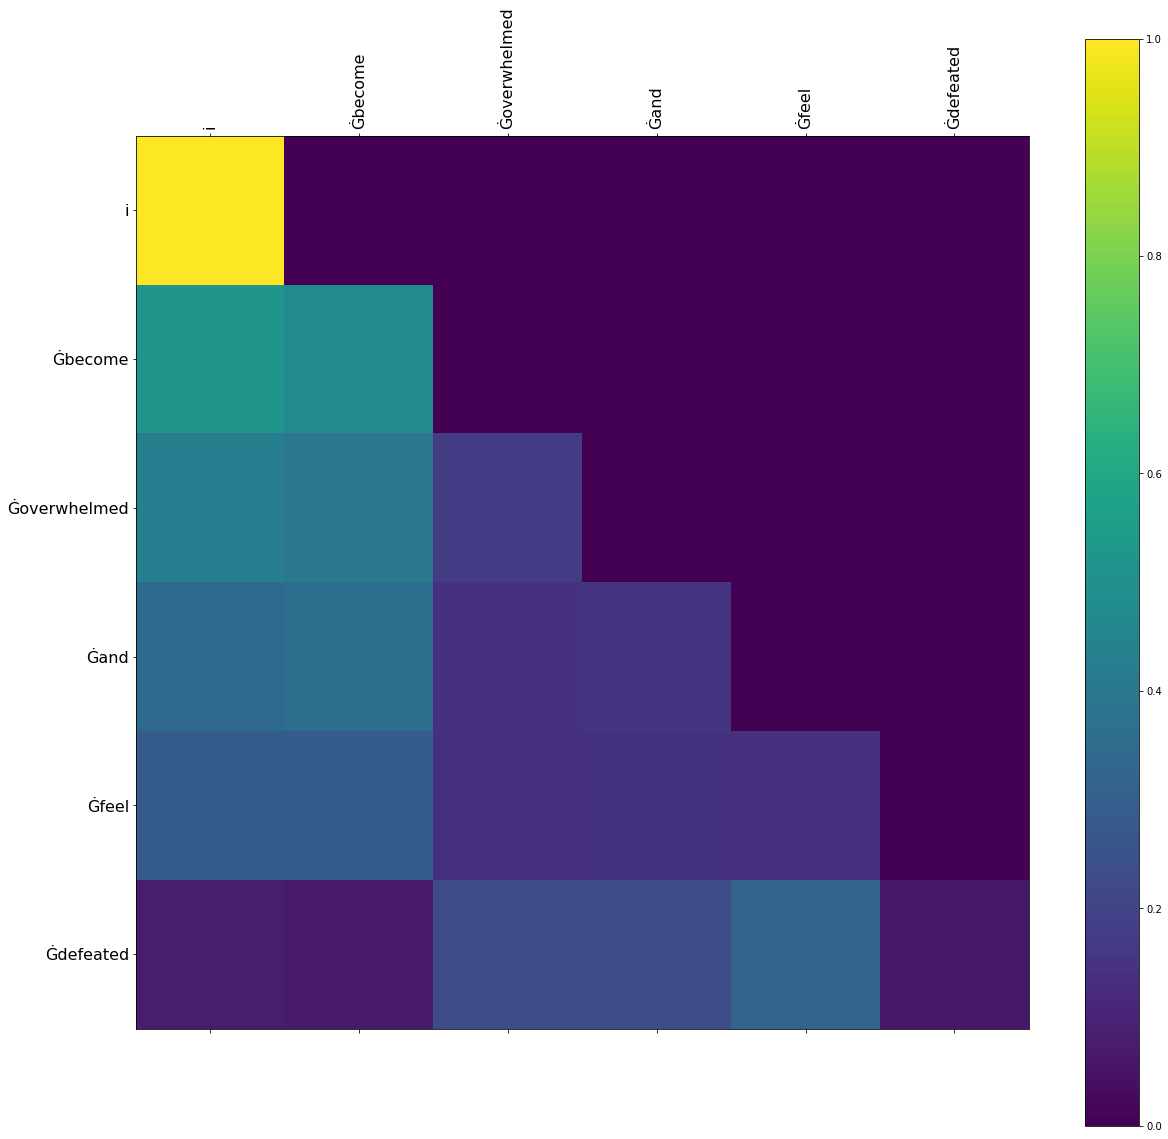

In [60]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

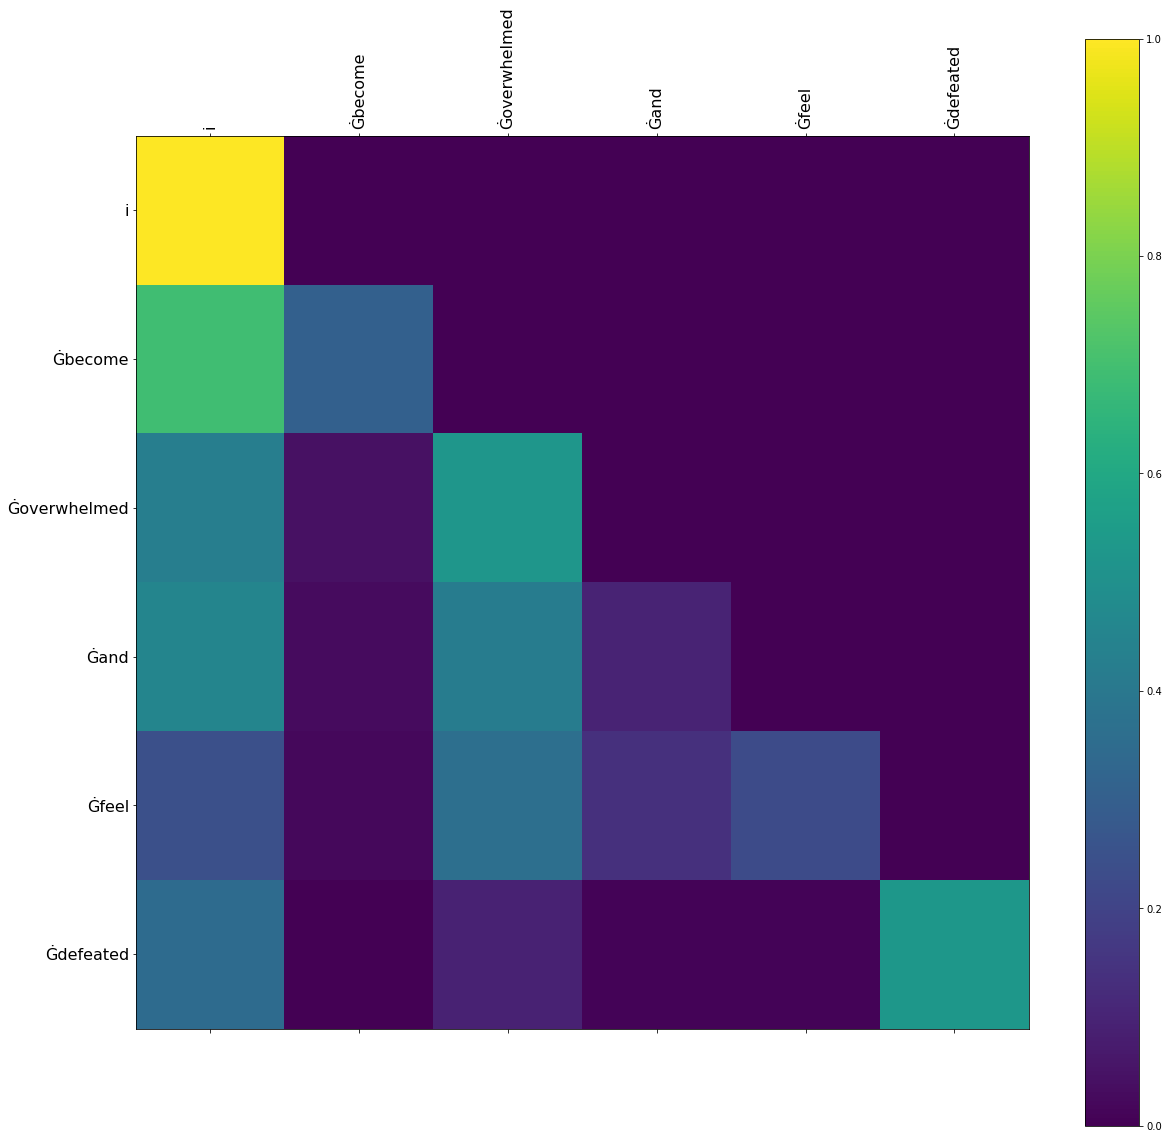

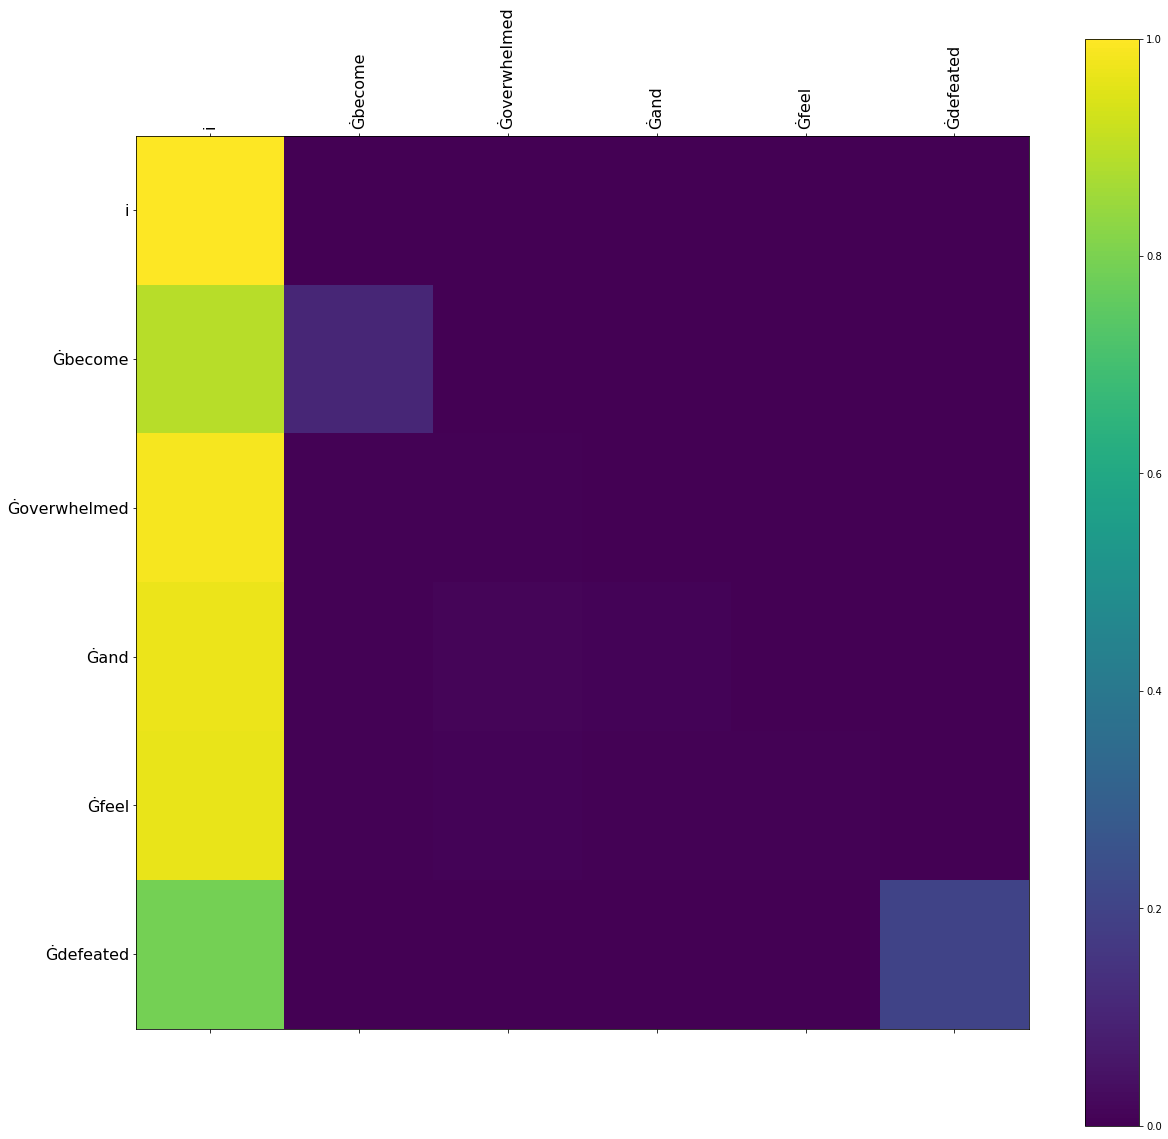

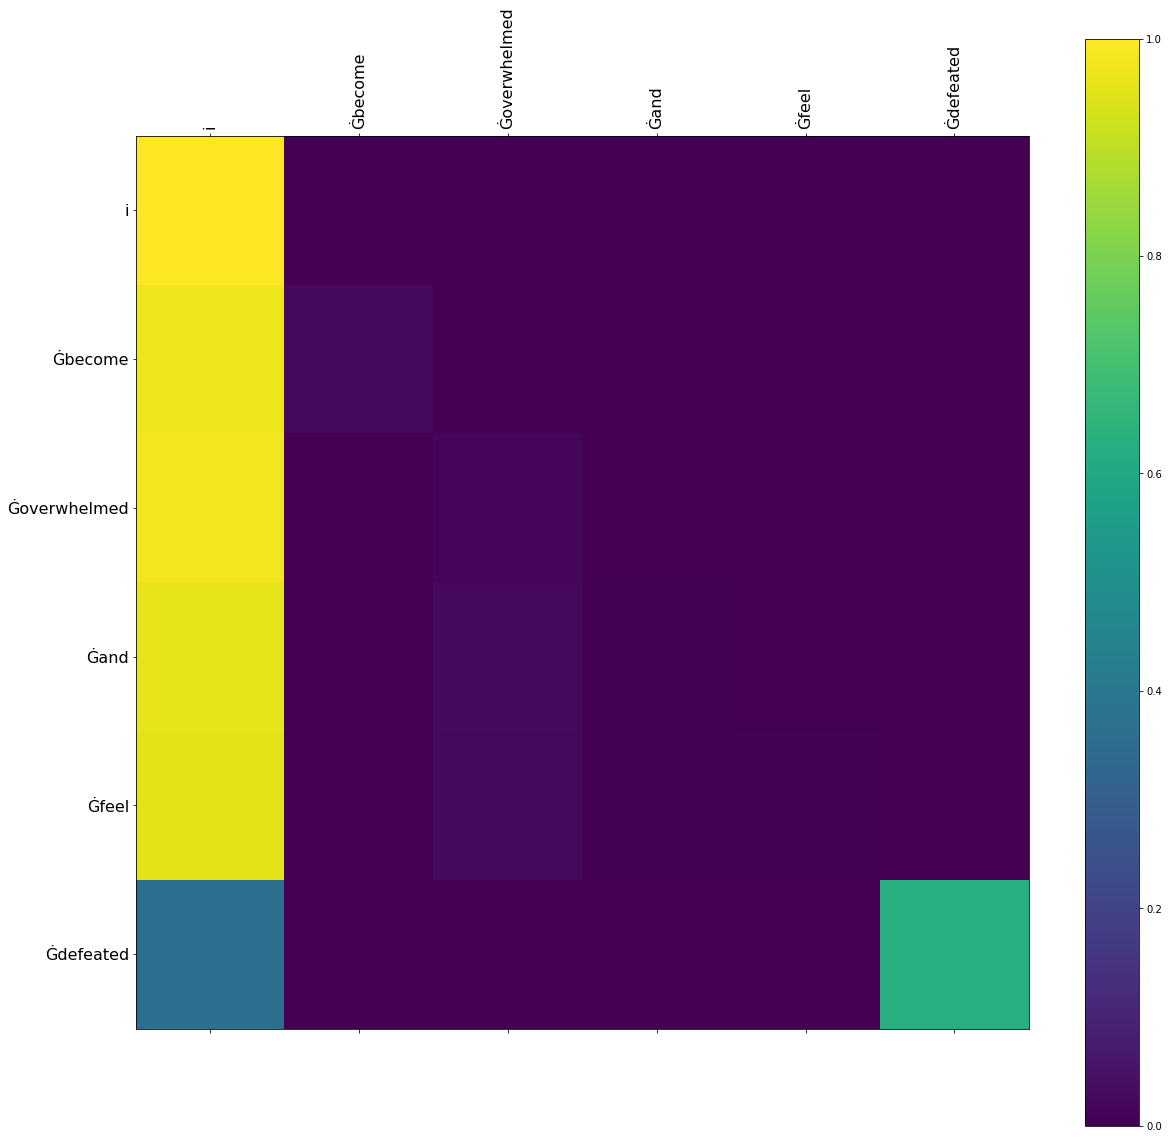

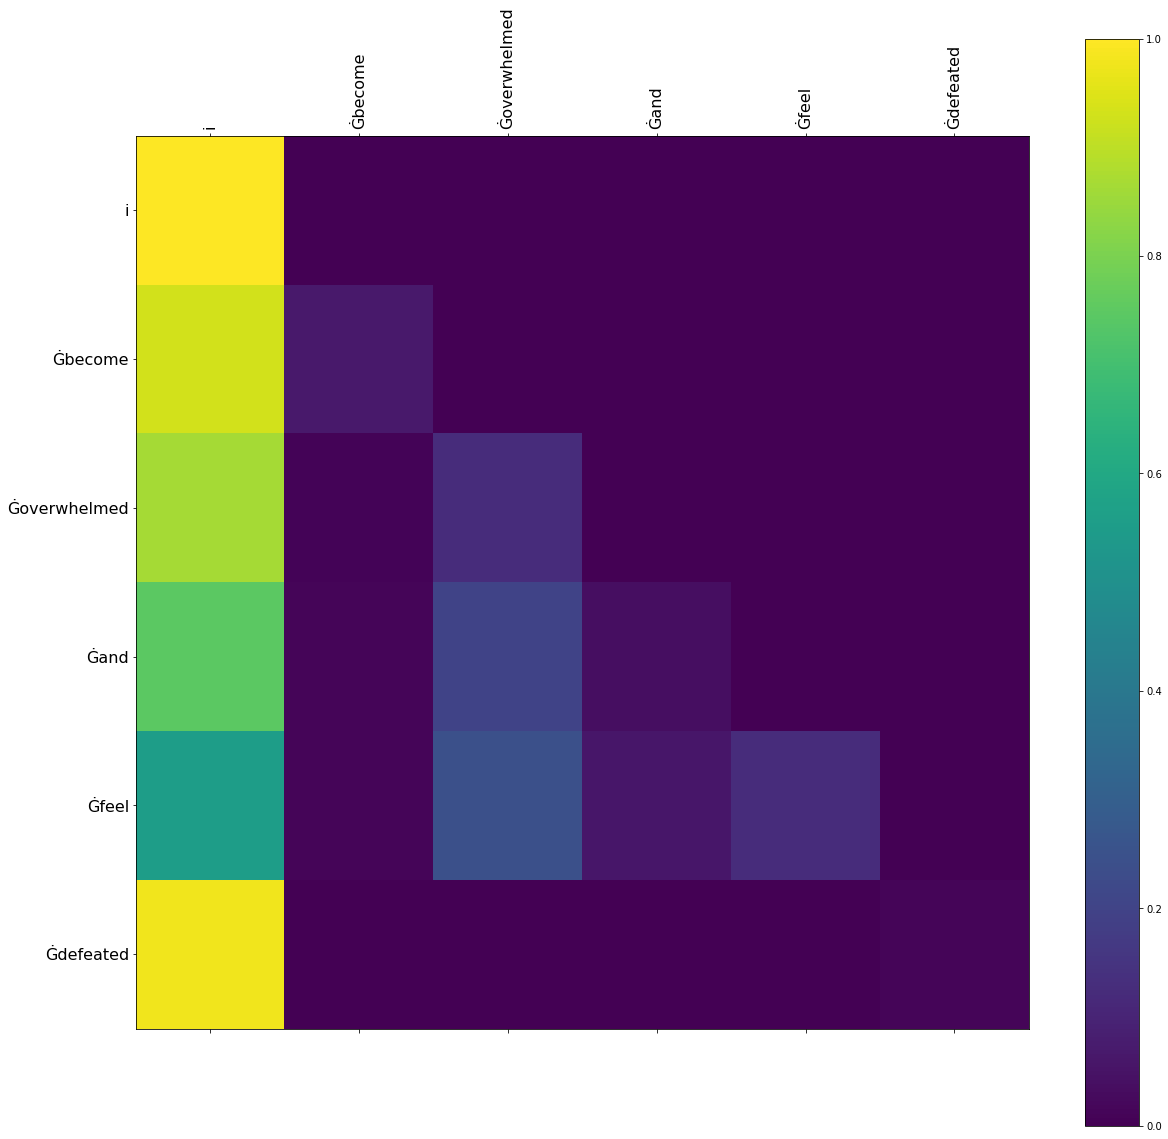

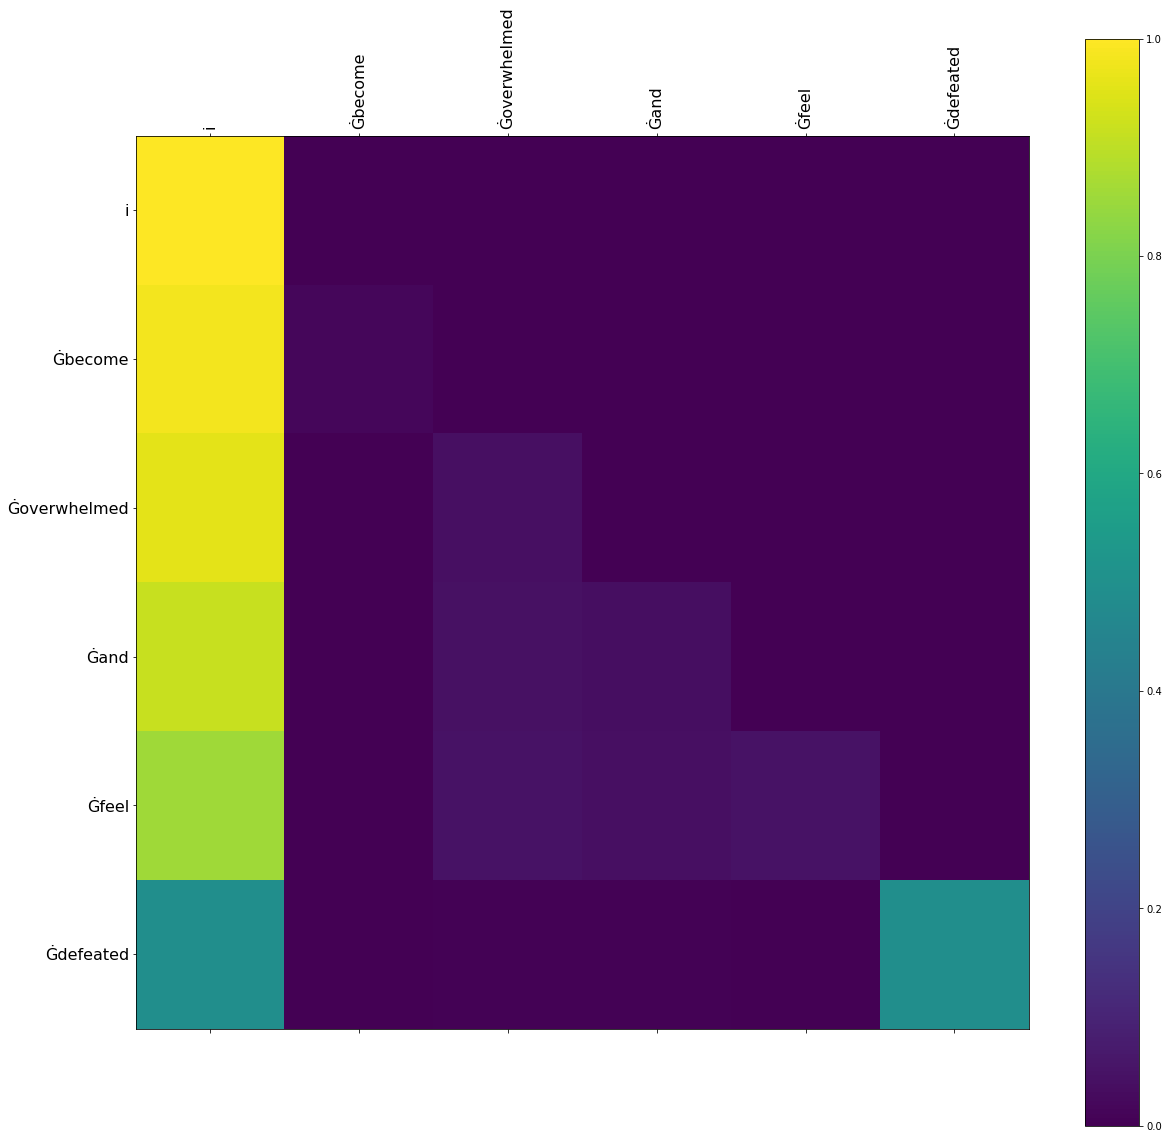

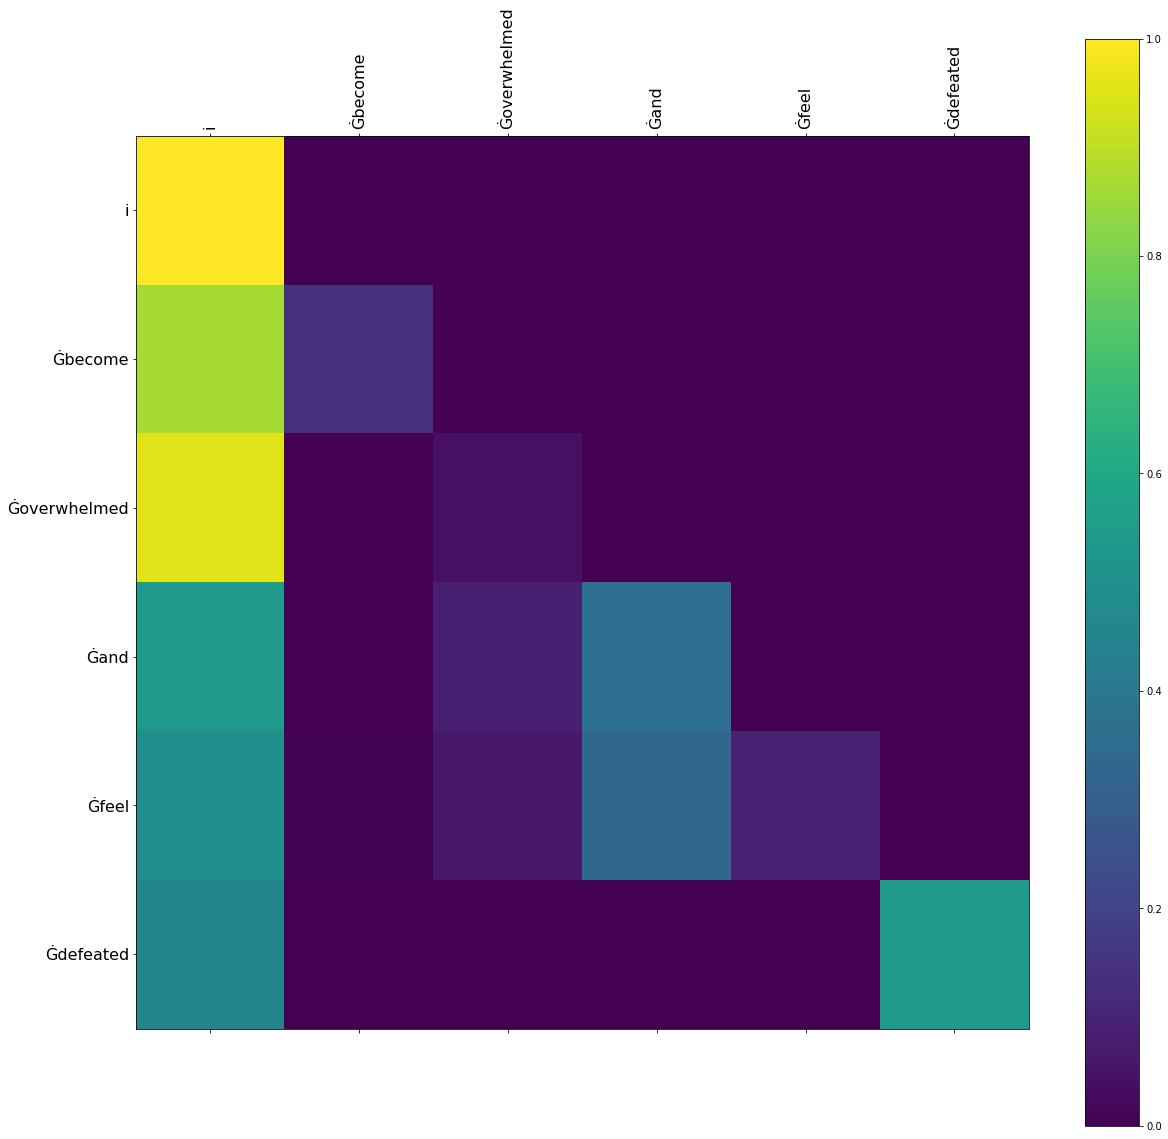

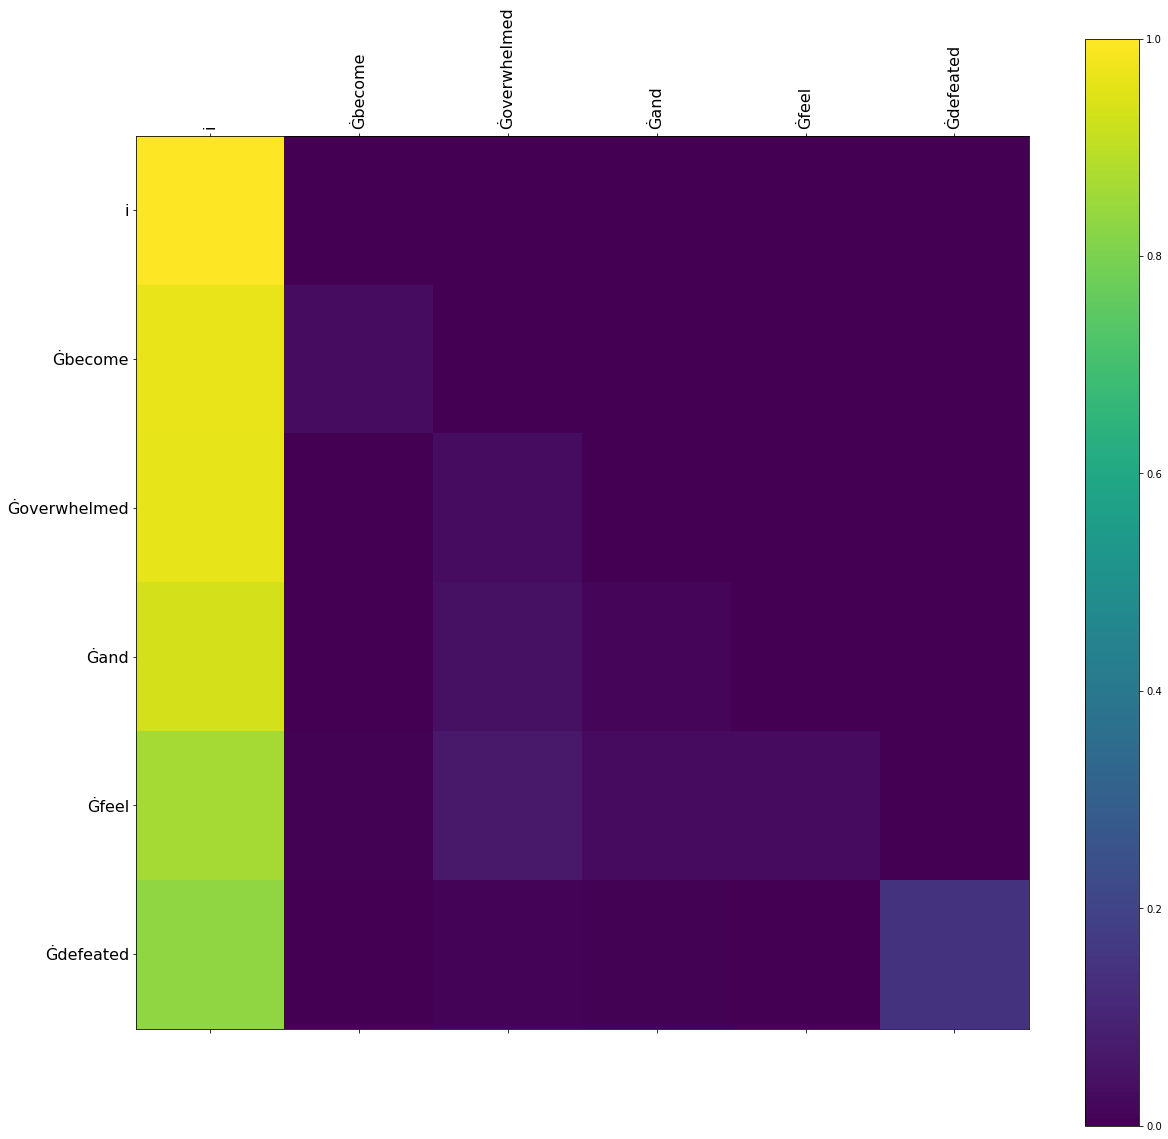

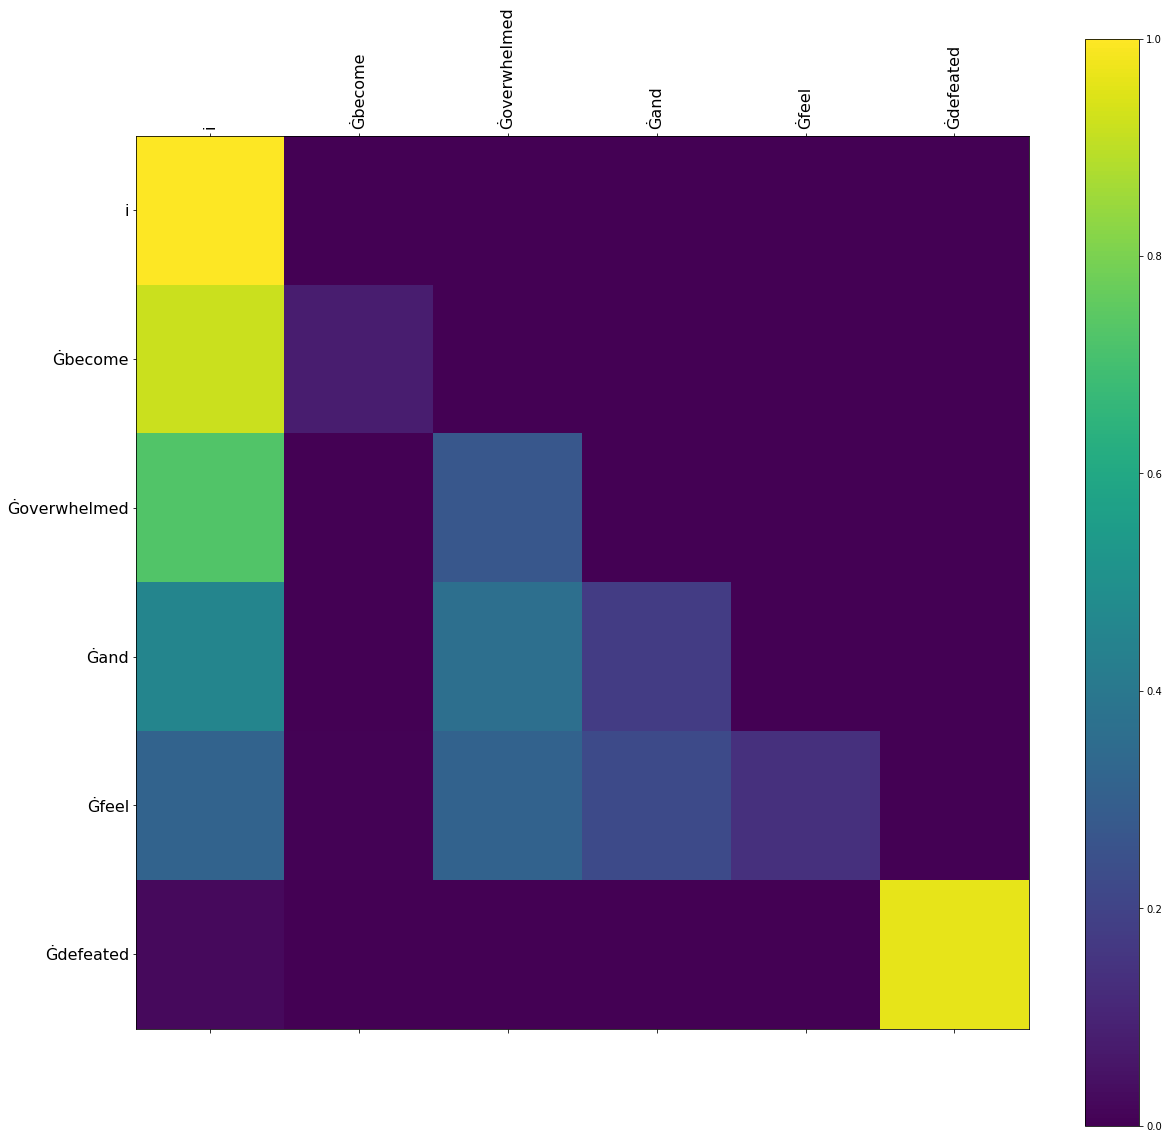

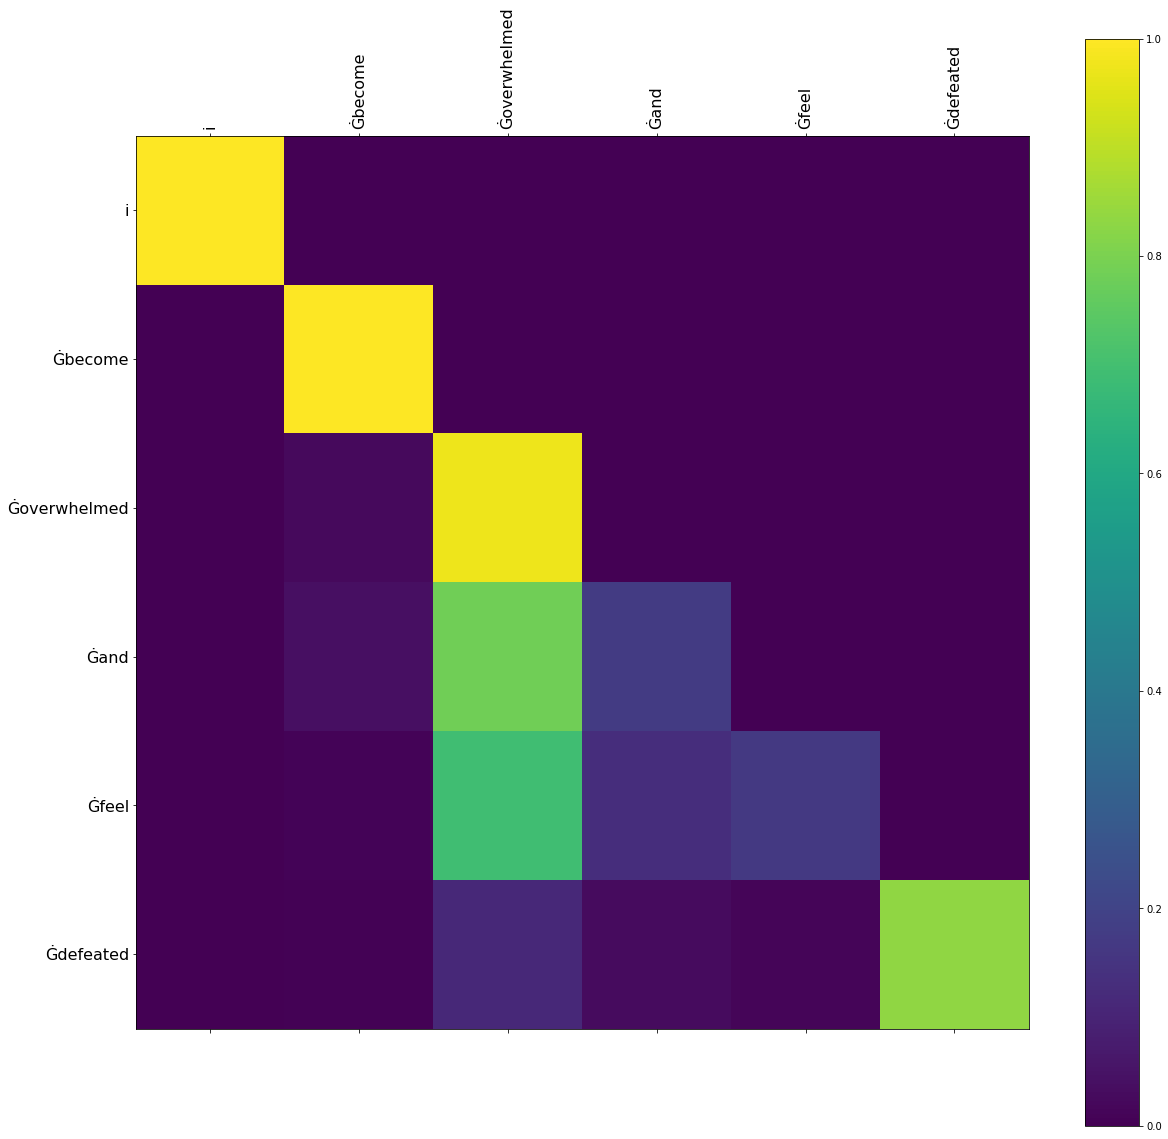

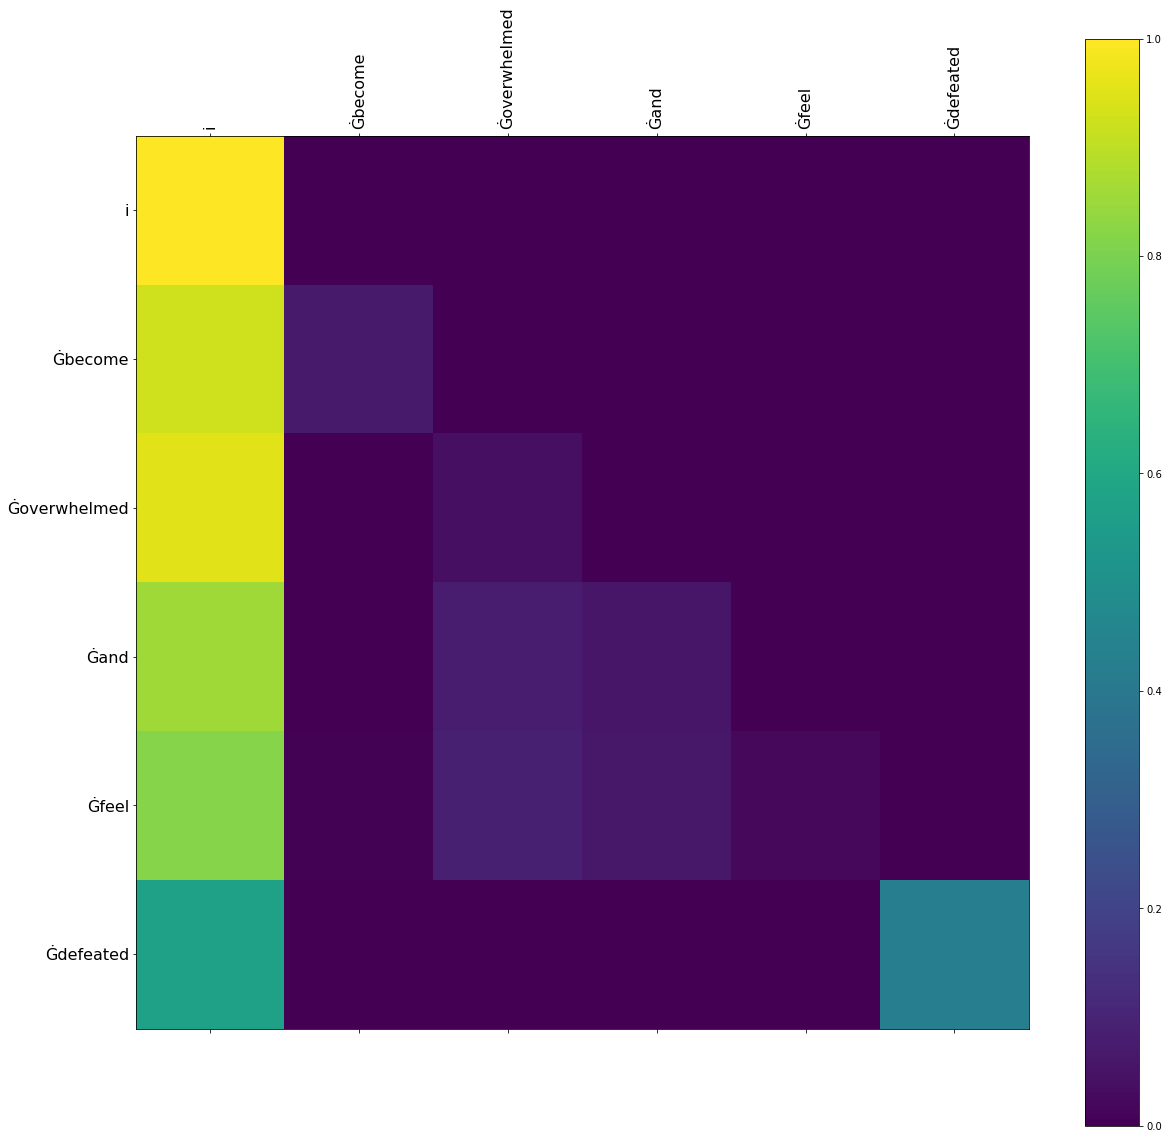

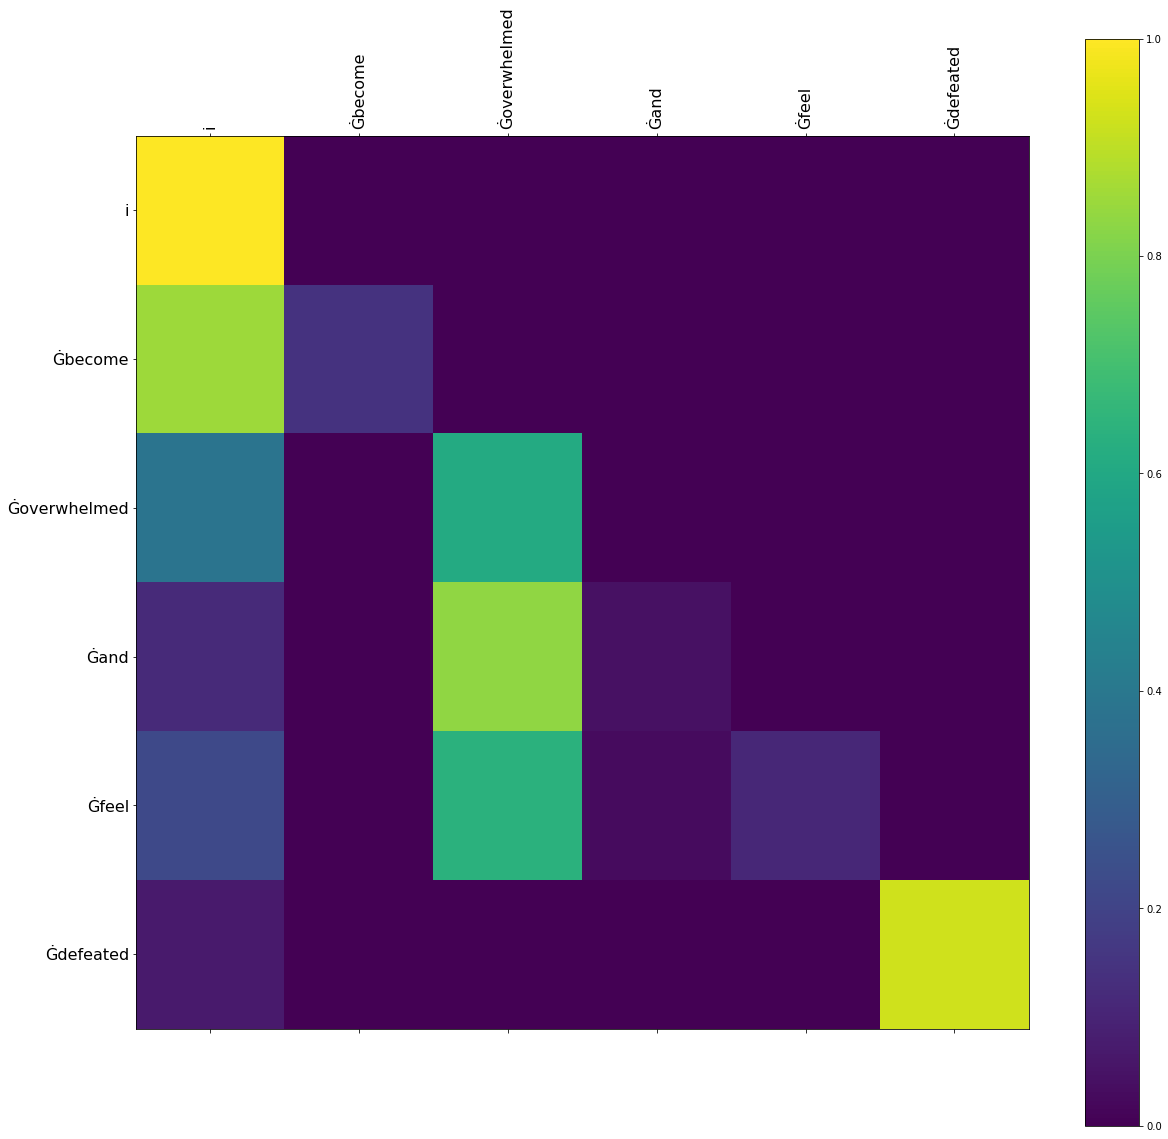

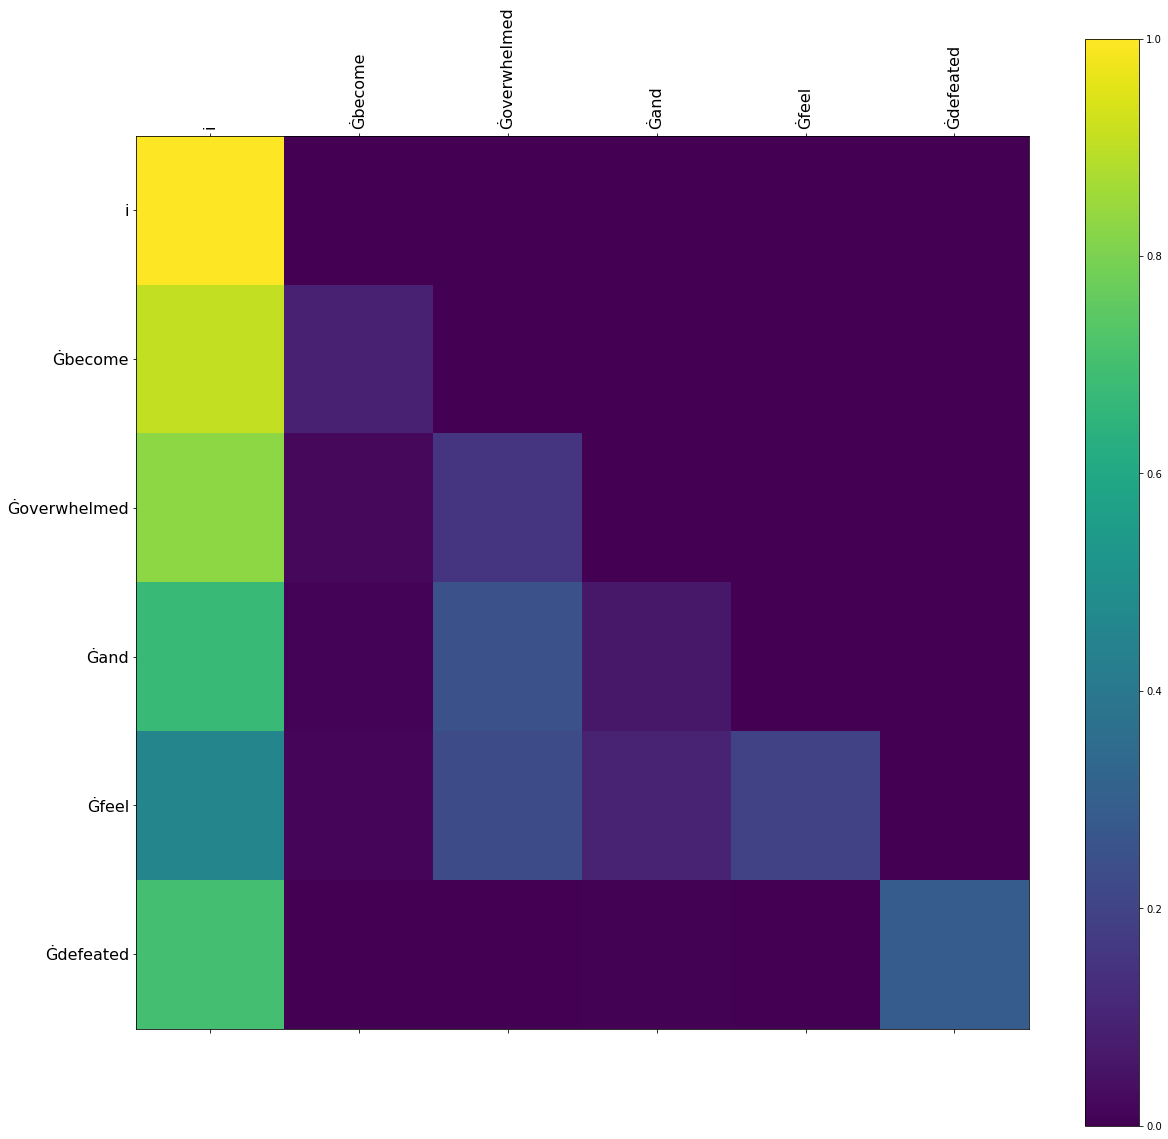

In [70]:
for i in range(12):
  show_attention(tokens, attns[-1][i])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [61]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [65]:
from tqdm.notebook import tqdm

num_epochs = 10
CLIP = 3
best_valid_acc = -np.inf

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_acc = 0
    train_loss = 0
    for batch in tqdm(train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_1(input_ids=tokens, attention_mask=mask)

        loss = criterion(output['logits'], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), CLIP)

        train_loss += loss.cpu().detach()
        train_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

        optimizer.step()

    valid_acc = 0
    valid_loss = 0
    model_1.eval()

    with torch.no_grad():
        for batch in valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_1(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          valid_loss += loss.cpu().detach()
          valid_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

 
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Train Acc: {train_acc / len(train_loader)},"
          f"Valid Acc: {valid_acc /  len(valid_loader)}")     

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_0.state_dict(), 'best_valid_acc_model_1.pt')      
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          # output = model_0(input_ids=tokens, attention_mask=mask)
          output = model_1(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          test_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

print(f"Test Acc: {test_acc / len(test_loader)}")

# Train Loss: 0.12827153503894806,Valid Loss: 0.13636481761932373,Train Acc: 0.9428750276565552,Valid Acc: 0.9380040168762207
# Test Acc: 0.9279233813285828

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.860334873199463,Valid Loss: 1.2689310312271118,Train Acc: 0.3775624930858612,Valid Acc: 0.5594757795333862


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.9030550718307495,Valid Loss: 0.4804191291332245,Train Acc: 0.6768749952316284,Valid Acc: 0.8271169066429138


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4627125859260559,Valid Loss: 0.2941378355026245,Train Acc: 0.8381249904632568,Valid Acc: 0.9007056355476379


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.29721176624298096,Valid Loss: 0.21100494265556335,Train Acc: 0.8914999961853027,Valid Acc: 0.9138104915618896


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.23326177895069122,Valid Loss: 0.1779920756816864,Train Acc: 0.9126874804496765,Valid Acc: 0.9279233813285828


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.18936403095722198,Valid Loss: 0.16485588252544403,Train Acc: 0.9268125295639038,Valid Acc: 0.930443525314331


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.17118073999881744,Valid Loss: 0.15359656512737274,Train Acc: 0.929312527179718,Valid Acc: 0.9294354915618896


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15532541275024414,Valid Loss: 0.1503993272781372,Train Acc: 0.9335625171661377,Valid Acc: 0.9324596524238586


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1371164470911026,Valid Loss: 0.14567387104034424,Train Acc: 0.9402499794960022,Valid Acc: 0.9375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.12827153503894806,Valid Loss: 0.13636481761932373,Train Acc: 0.9428750276565552,Valid Acc: 0.9380040168762207
Test Acc: 0.8825604915618896


In [66]:
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_1(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          test_acc += (targets==torch.argmax(output['logits'], dim=1)).sum().cpu().detach()\
                     / len(targets)

print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.9279233813285828


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [67]:
text = emotion_dataset["train"]["text"][27] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

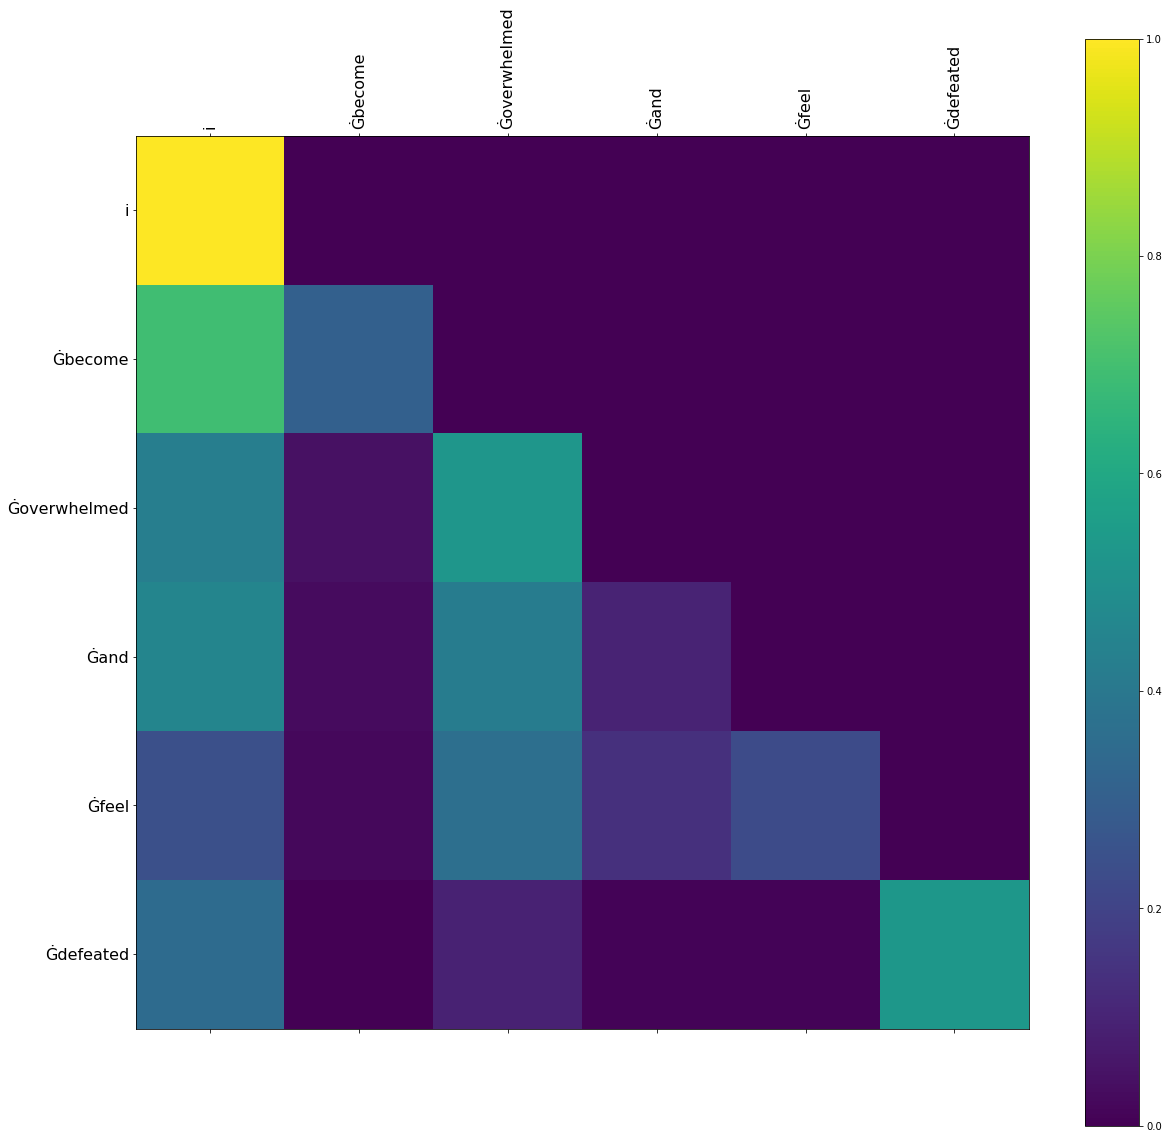

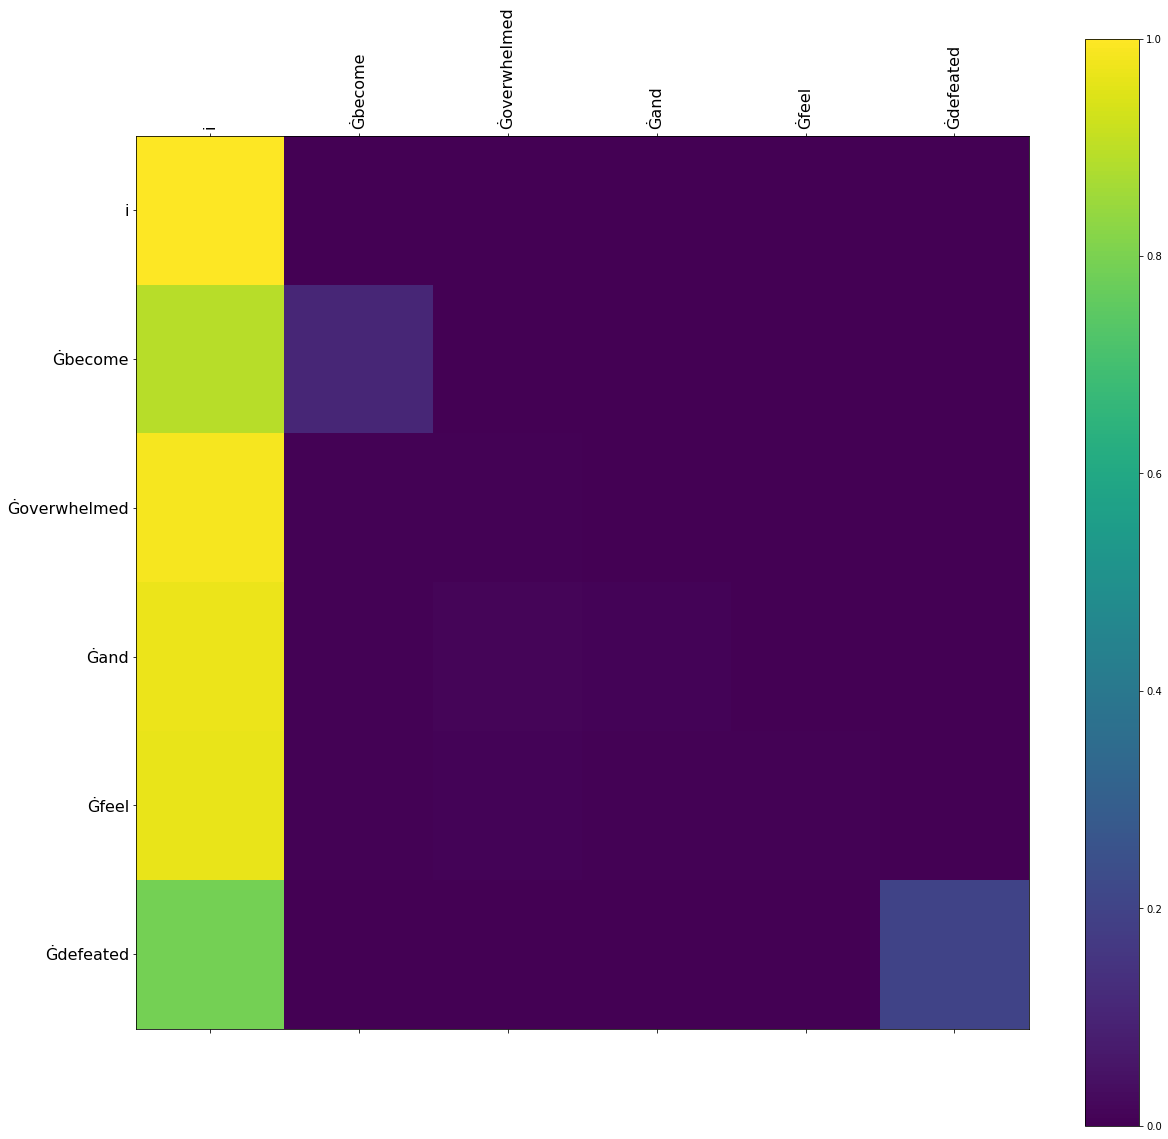

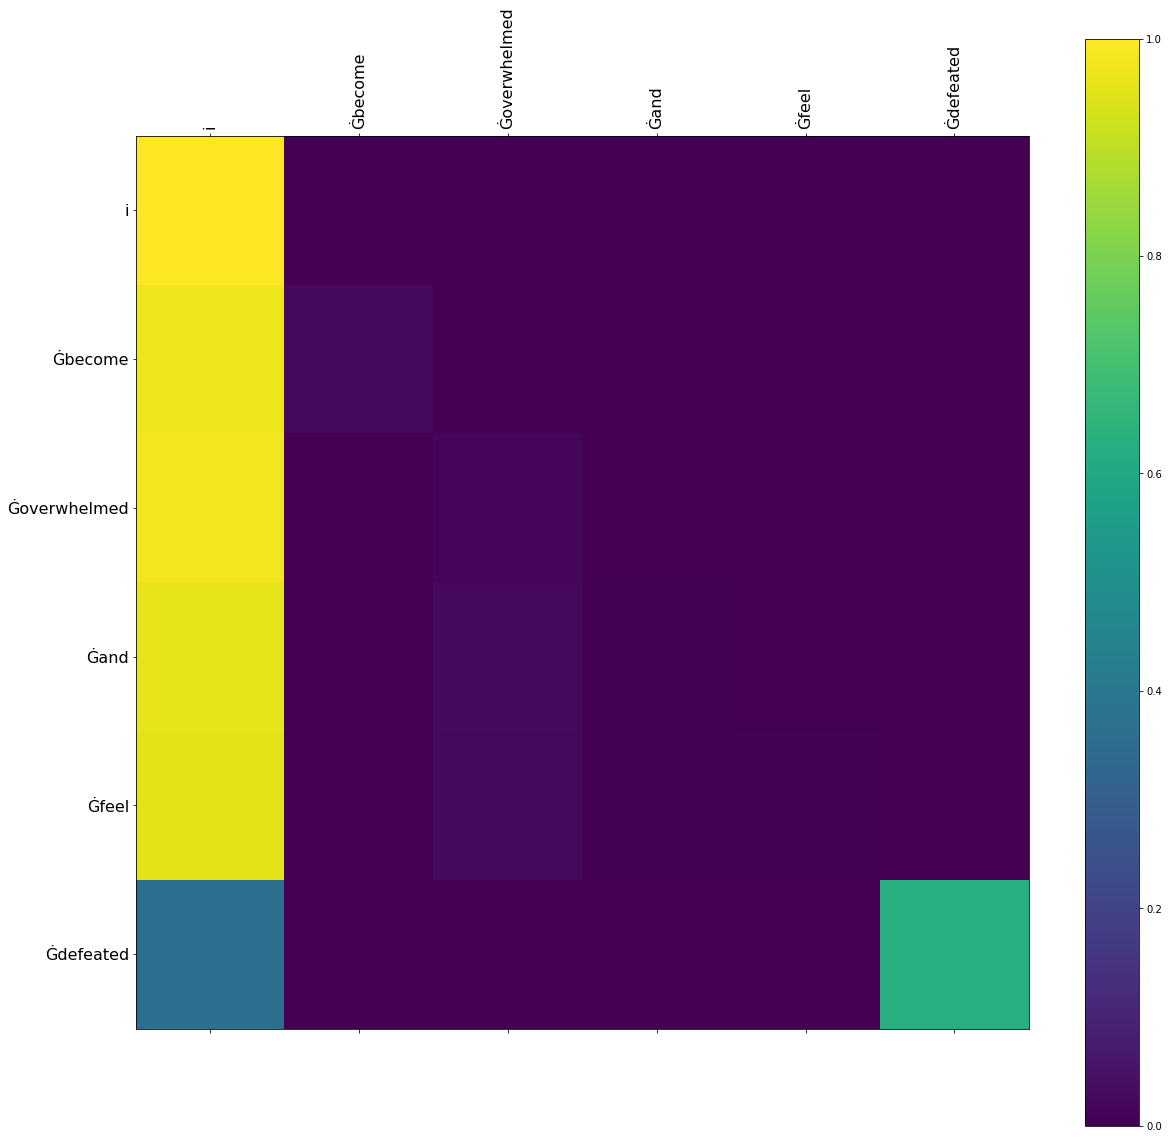

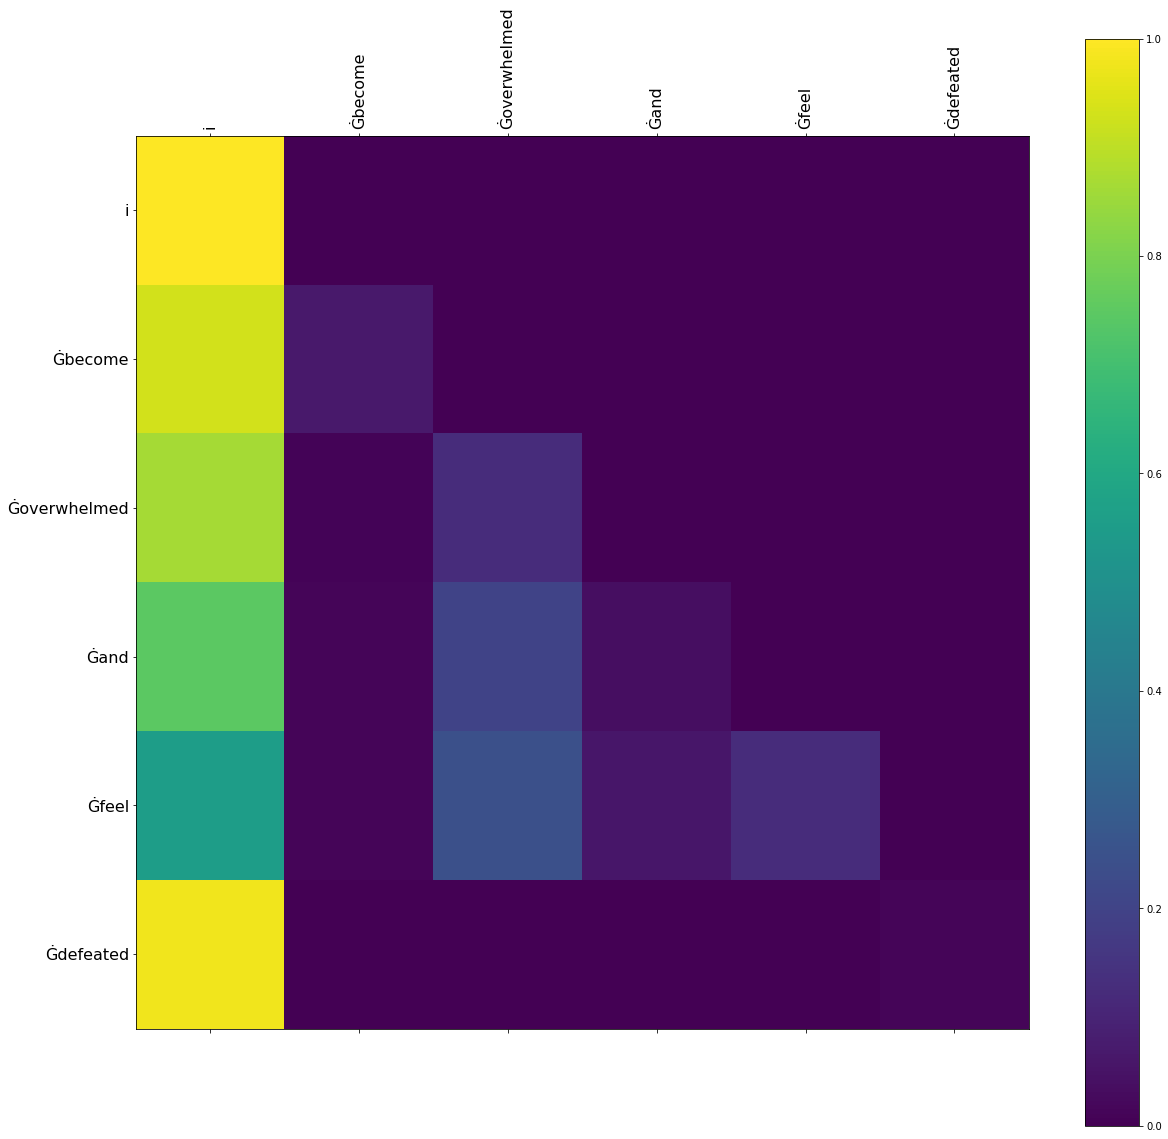

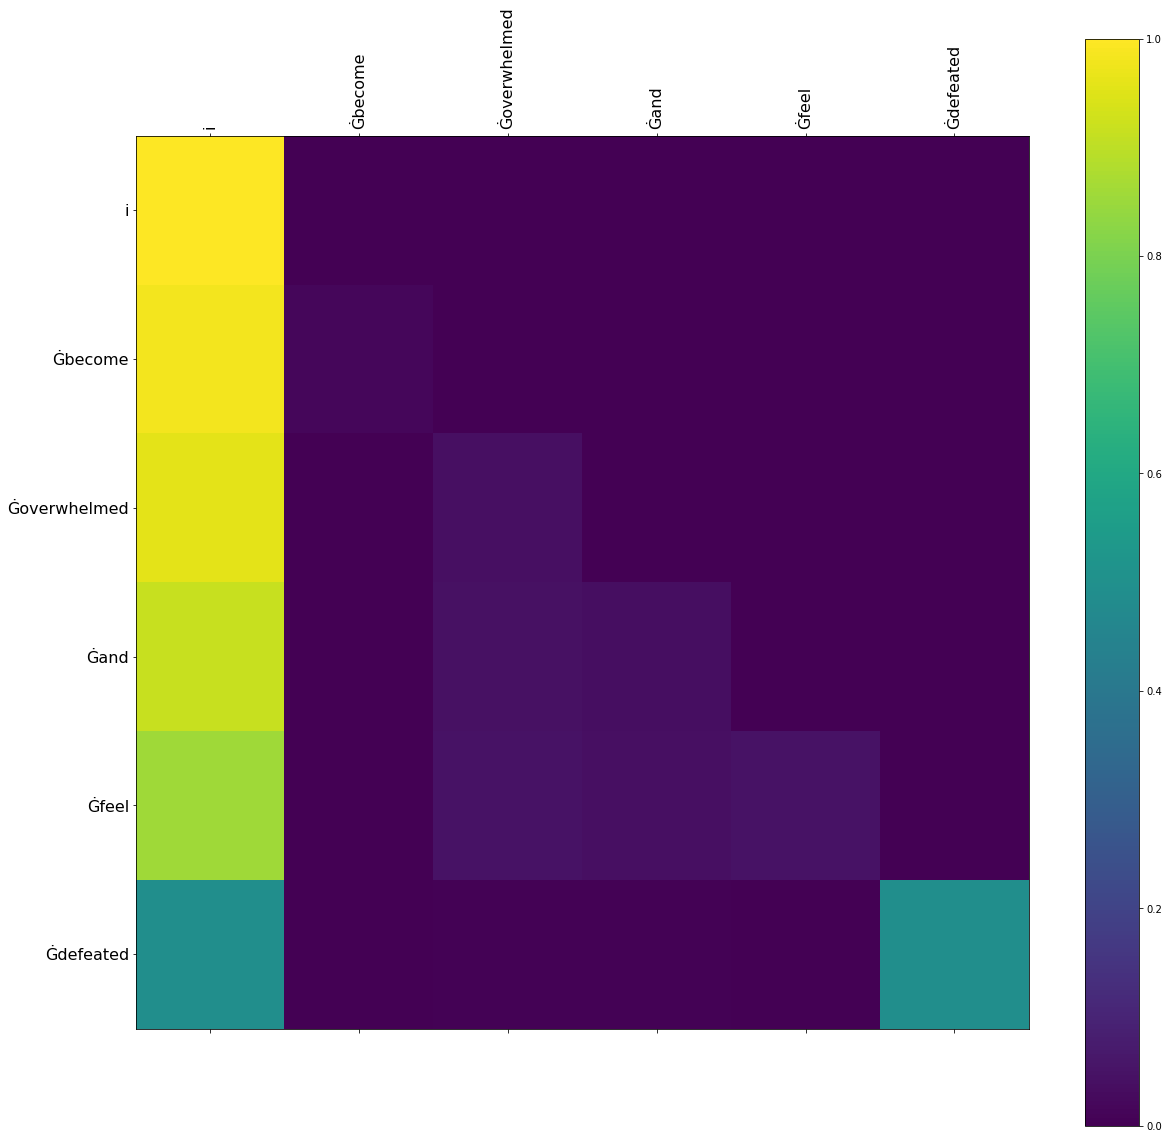

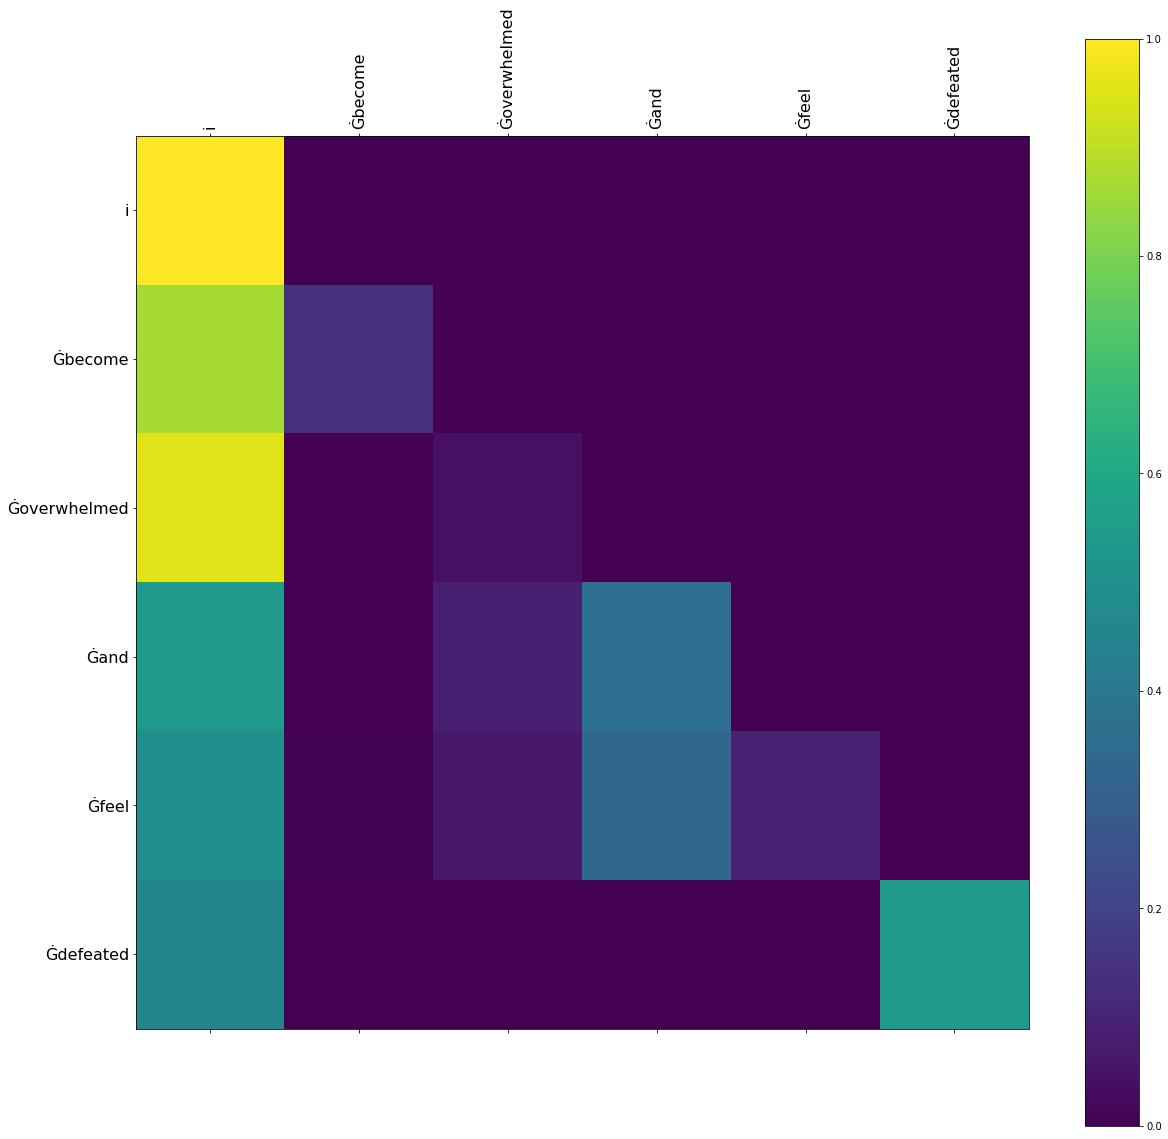

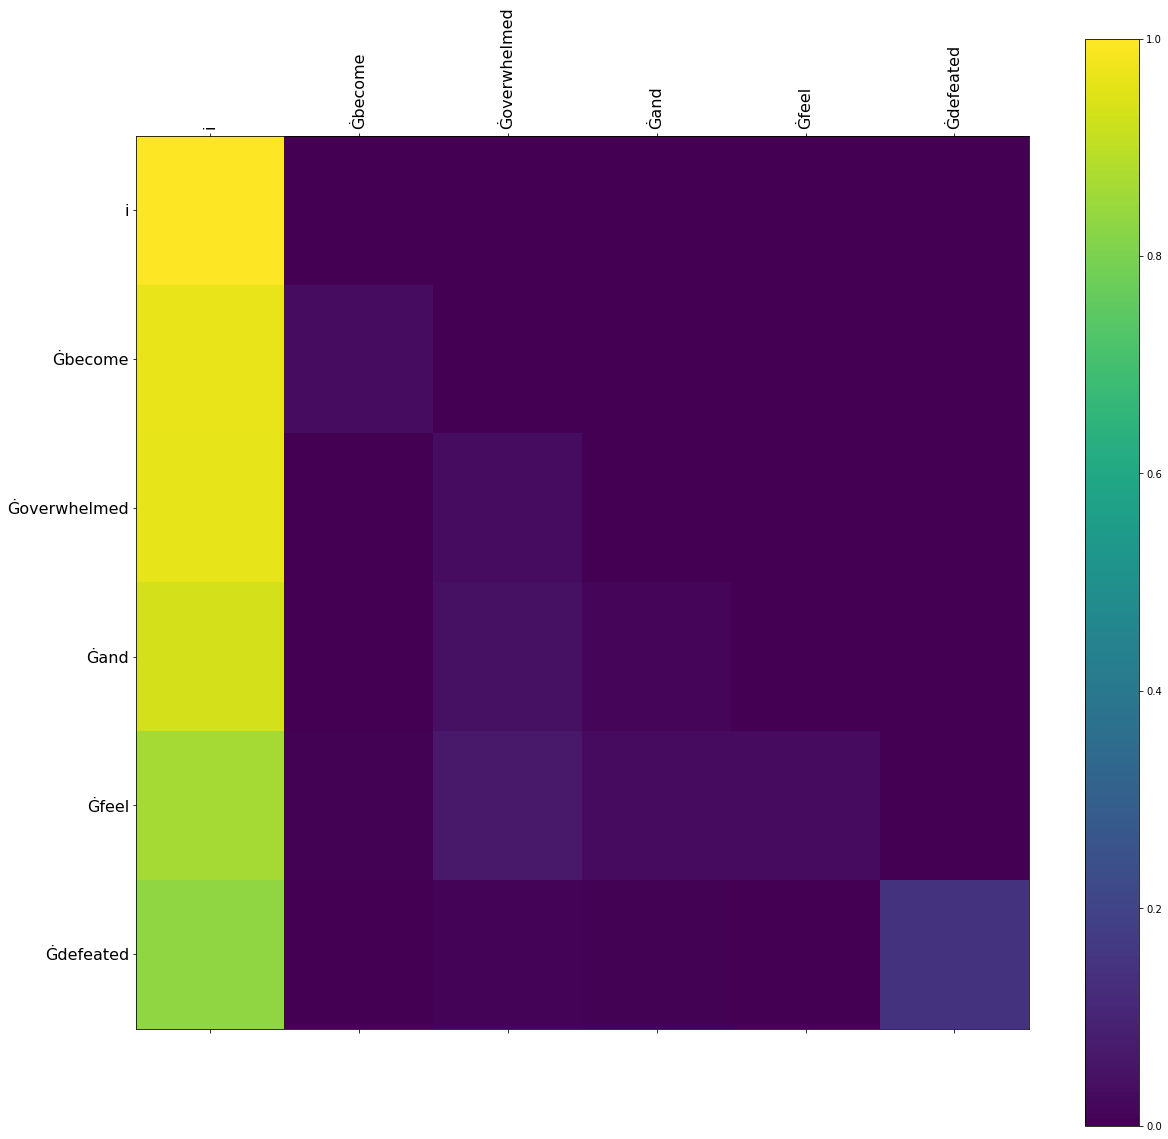

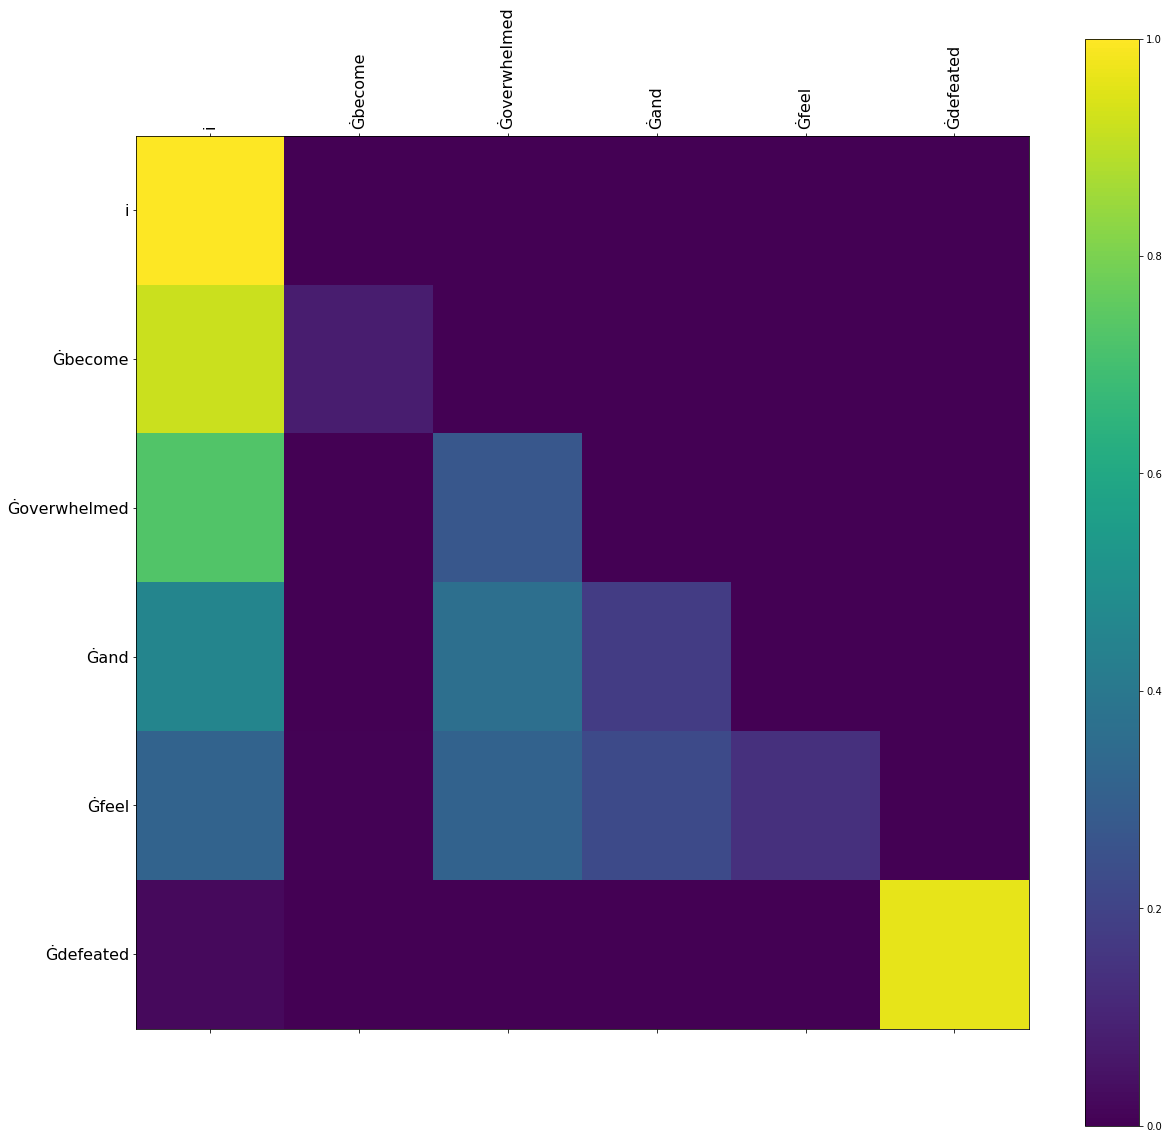

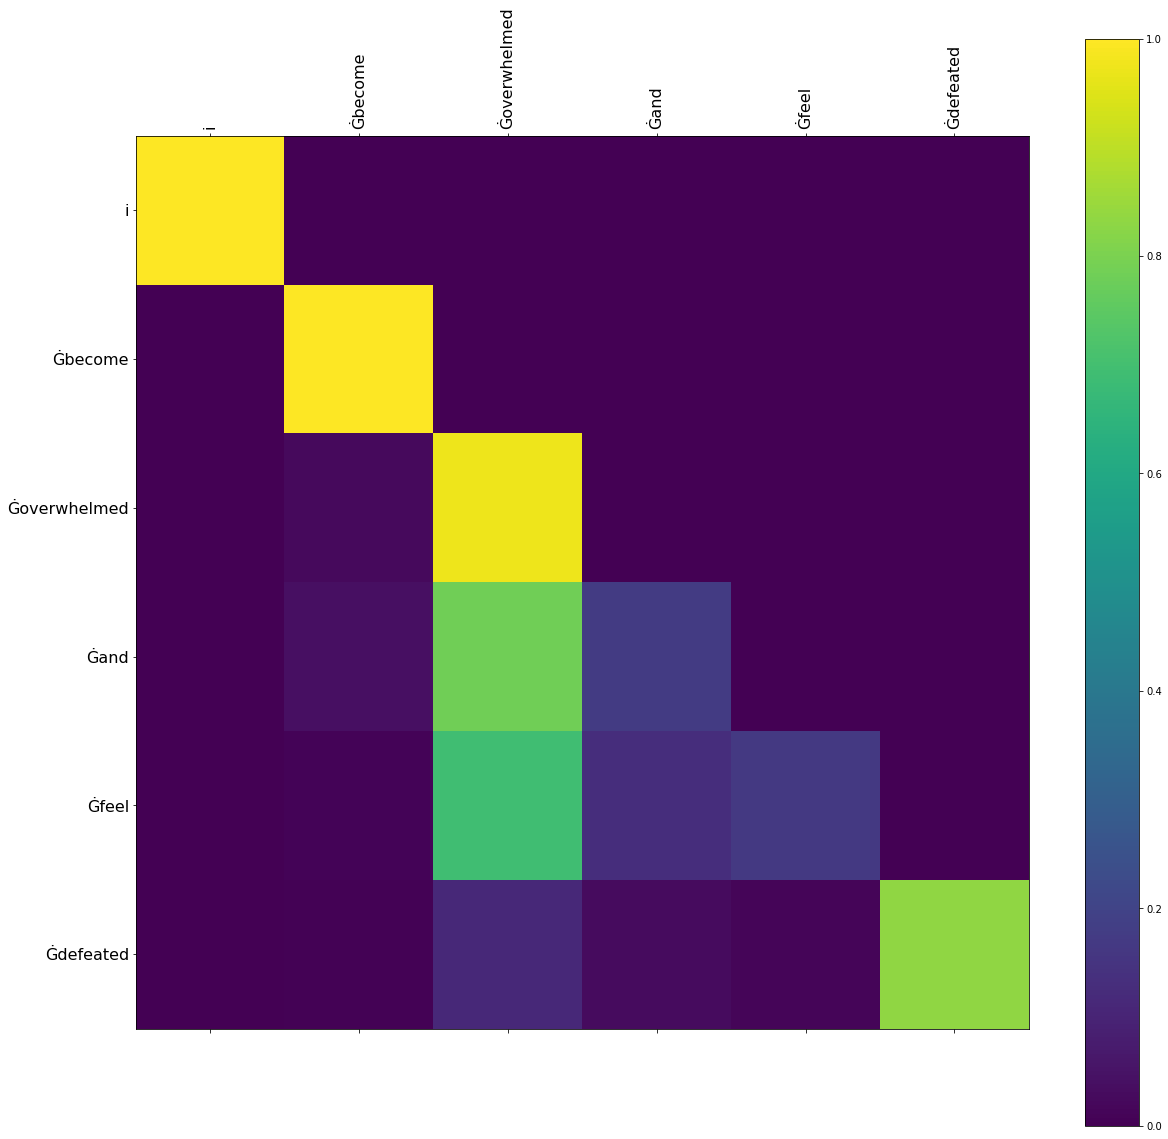

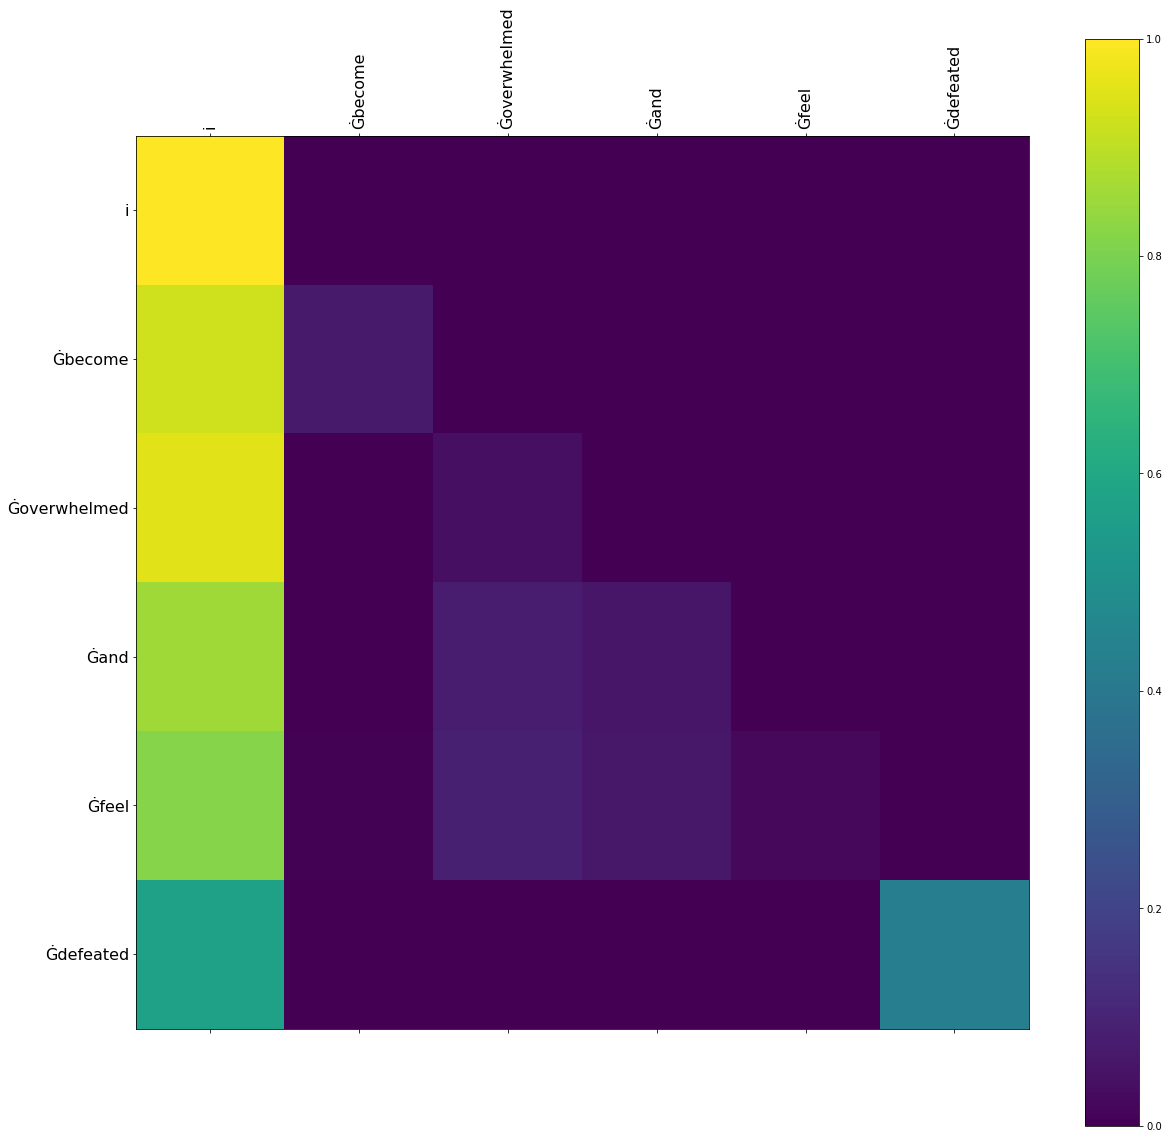

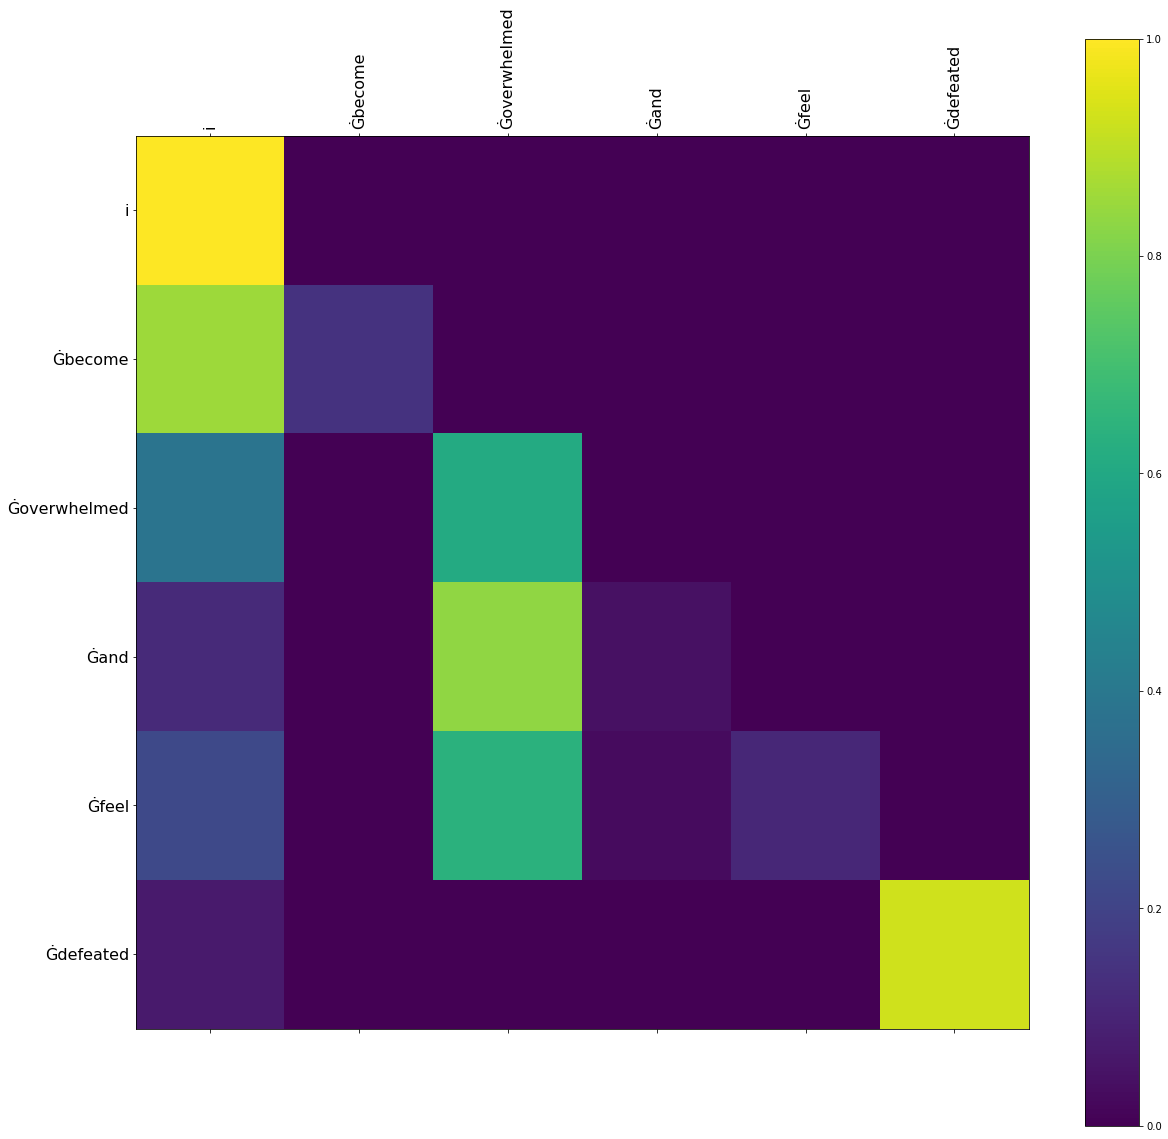

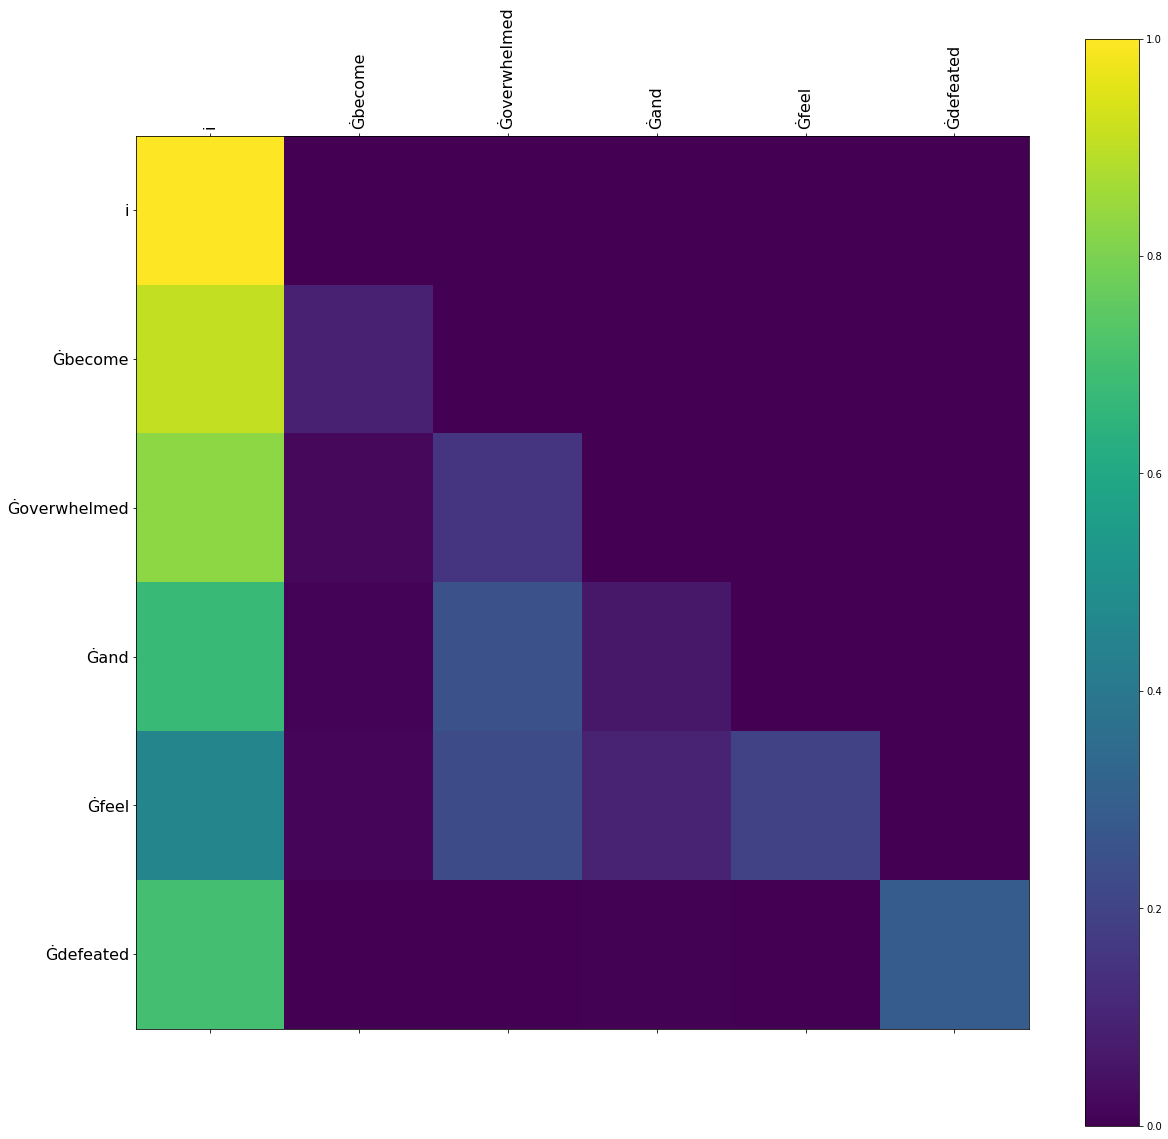

In [71]:
attns_1 = get_attention_matrixes(model_1, tokenizer, text)
for i in range(12):
  show_attention(tokens, attns_1[-1][i])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

1. Предобученная модель с первой же эпохи показала accuracy лучше, чем обычная модель, и училась намного быстрее. В итоге предобученная модель показала лучше качество на тесте - 0.928 против 0.883
2. Я просмотрела карты внимания для всех слоев и заметила несколько вариантов того, на какие слова модель обращает внимание: на само слово, на первое слово, на само слово и на первое слово, на несколько или одно из предыдущих слов и на первое слово и т.д. Есть карты внимания, на которых для всех слов представлено одинаковое поведение, а есть карты с различным поведением внимания для различных слов. 